# Predicting house prices

In [1]:
#upload some useful libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy import stats
import warnings
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.tree import DecisionTreeRegressor
warnings.filterwarnings('ignore')
%matplotlib inline
from math import radians, sin, cos, sqrt, atan2
from sklearn.ensemble import RandomForestRegressor

In [2]:
# loading data
df_train = pd.read_csv('./train.csv')

In [3]:
# check columns to view the data; its features and labels to be included in the model and trailing spaces
df_train.columns

Index(['id', 'price', 'balcony', 'conditions', 'construction_year', 'latitude',
       'longitude', 'energy_efficiency', 'expenses', 'floor', 'garden',
       'n_bathrooms', 'elevator', 'total_floors', 'n_rooms',
       'proximity_to_center', 'surface'],
      dtype='object')

In [4]:
# checking for numerical and categorical variables

# select numerical columns
numerical_cols = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print('Numerical columns:', numerical_cols)

# select categorical columns
categorical_cols = df_train.select_dtypes(include=['object']).columns.tolist()
print('Categorical columns:', categorical_cols)

Numerical columns: ['id', 'price', 'construction_year', 'latitude', 'longitude', 'energy_efficiency', 'expenses', 'floor', 'n_bathrooms', 'elevator', 'total_floors', 'n_rooms', 'proximity_to_center', 'surface']
Categorical columns: ['balcony', 'conditions', 'garden']


## Target variable - price

In [5]:
# getting descriptive statistics of the target variable
df_train['price'].describe()

count    4.631200e+04
mean     5.031879e+05
std      1.106504e+06
min      1.540000e+02
25%      1.990000e+05
50%      3.150000e+05
75%      5.150000e+05
max      7.200000e+07
Name: price, dtype: float64

In [6]:
len(df_train['price']) # 46312 observations

46312

We see that IQ contains values with 10^5, while the lowest value has 10^2 and the highest 10^7. This may point to outliers, which we want to investigate more closely and possibly delete. We can also see the distribution on distplot below:

<AxesSubplot:xlabel='price', ylabel='Density'>

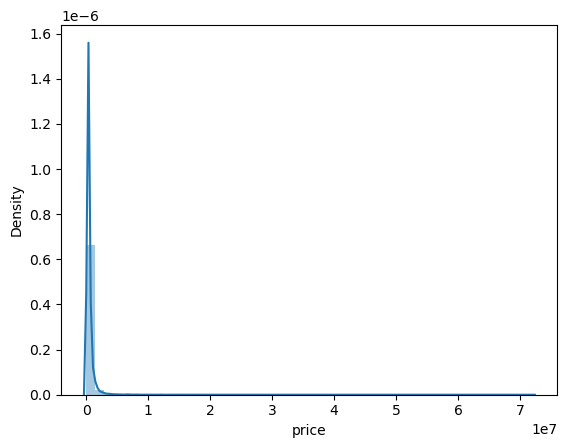

In [7]:
sns.distplot(df_train['price'])

It can be seen from the descriptive statistics as well from the histogram displaying the distribution of price, there is a significant variation for data. While it is concentrated for values of order 10^5, there are still values 100 times bigger and 1000 times smaller (order 10^7 and 10^2). Let's apply the logarithmic transformation to account for this effect.

In [8]:
df_train['price_log']=np.log(df_train['price'])

<AxesSubplot:xlabel='price_log', ylabel='Density'>

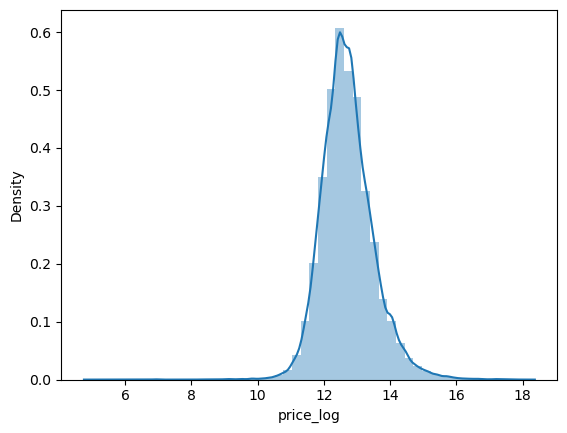

In [9]:
sns.distplot(df_train['price_log'])

We can see that after the logarithmic transformation, our data approximately follows normal distribution, which is the desirable property from the perspective of modelling.

In [10]:
# Data skewness and kurtosis
print("Skewness: %f" % df_train['price_log'].skew(), "for normal distribution: 0.") 
print("Kurtosis: %f" % df_train['price_log'].kurt(), "for normal distribution: 3.")

Skewness: 0.529227 for normal distribution: 0.
Kurtosis: 2.586761 for normal distribution: 3.


Not perfect but satisfactory.

## Encoding categorical variables

Before investigating mutual dependencies between variables, we will first express categorical variables in numerical terms in order to be able to include them in our analysis from the beginning. Categorical variables include: conditions, balcony, garden.

### Conditions

In [11]:
df_train["conditions"].value_counts()

Buono stato / Abitabile      21827
Ottimo / Ristrutturato       10533
Nuovo / Nuova costruzione     7045
Da ristrutturare              5678
Name: conditions, dtype: int64

In [12]:
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

# a list of categories in the desired order
category_order = ['Unknown', 'Da ristrutturare', 'Buono stato / Abitabile', 'Ottimo / Ristrutturato', 'Nuovo / Nuova costruzione']

# fill NaN values with a string 'Unknown' in order to be able to use the OrdinalEncoder
df_train['conditions'] = df_train['conditions'].fillna('Unknown')

# create an instance of the OrdinalEncoder and fit on the category order
ordinal_encoder = OrdinalEncoder(categories=[category_order])

# encode the categories in the specified order
conditions_encoded = ordinal_encoder.fit_transform(df_train[["conditions"]])

# we want the categories to take values between 0 and 3 and 'Unknown' to take the value of -1 (later we will replace it with
# one of the categories while taking care of missing values)
# create an instance of the MinMaxScaler and fit on the encoded values
scaler = MinMaxScaler(feature_range=(-1, 3))
conditions_scaled = scaler.fit_transform(conditions_encoded)

print(conditions_scaled[:10])

[[1.]
 [1.]
 [1.]
 [2.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [2.]]


In [13]:
df_train["conditions"]=conditions_scaled
print(df_train["conditions"]) # type float64

0        1.0
1        1.0
2        1.0
3        2.0
4        1.0
        ... 
46307    1.0
46308    0.0
46309    1.0
46310    1.0
46311    2.0
Name: conditions, Length: 46312, dtype: float64


In [14]:
ordinal_encoder.categories_

[array(['Unknown', 'Da ristrutturare', 'Buono stato / Abitabile',
        'Ottimo / Ristrutturato', 'Nuovo / Nuova costruzione'],
       dtype=object)]

In [15]:
# We will convert "Unknown" back to nan, we converted it to Unknown only temporarily in order to use the encoder
df_train["conditions"].replace(-1, np.nan, inplace=True)

### Balcony

In [16]:
df_train["balcony"].value_counts()

True    30869
Name: balcony, dtype: int64

In [17]:
df_train["balcony"][df_train["balcony"]==True]=1
df_train["balcony"][df_train["balcony"].isna()]=-1 # needed to convert dtype of "balcony" to int
df_train["balcony"].astype(int)

0        1
1       -1
2       -1
3       -1
4        1
        ..
46307    1
46308    1
46309    1
46310    1
46311    1
Name: balcony, Length: 46312, dtype: int32

In [18]:
df_train["balcony"].replace(-1, np.nan, inplace=True)
df_train["balcony"]

0        1.0
1        NaN
2        NaN
3        NaN
4        1.0
        ... 
46307    1.0
46308    1.0
46309    1.0
46310    1.0
46311    1.0
Name: balcony, Length: 46312, dtype: float64

### Garden

In [19]:
df_train["garden"].value_counts()

True    14783
Name: garden, dtype: int64

In [20]:
df_train["garden"][df_train["garden"]==True]=1
df_train["garden"][df_train["garden"].isna()]=-1 # needed to convert dtype of "balcony" to int
df_train["garden"].astype(int)
df_train["garden"].replace(-1, np.nan, inplace=True)
df_train["garden"]

0        NaN
1        NaN
2        NaN
3        1.0
4        NaN
        ... 
46307    NaN
46308    NaN
46309    NaN
46310    1.0
46311    NaN
Name: garden, Length: 46312, dtype: float64

In [21]:
print(df_train["garden"].value_counts(), df_train["balcony"].value_counts())

1.0    14783
Name: garden, dtype: int64 1.0    30869
Name: balcony, dtype: int64


## Correlation heatmap - investigating dependencies between variables

<AxesSubplot:>

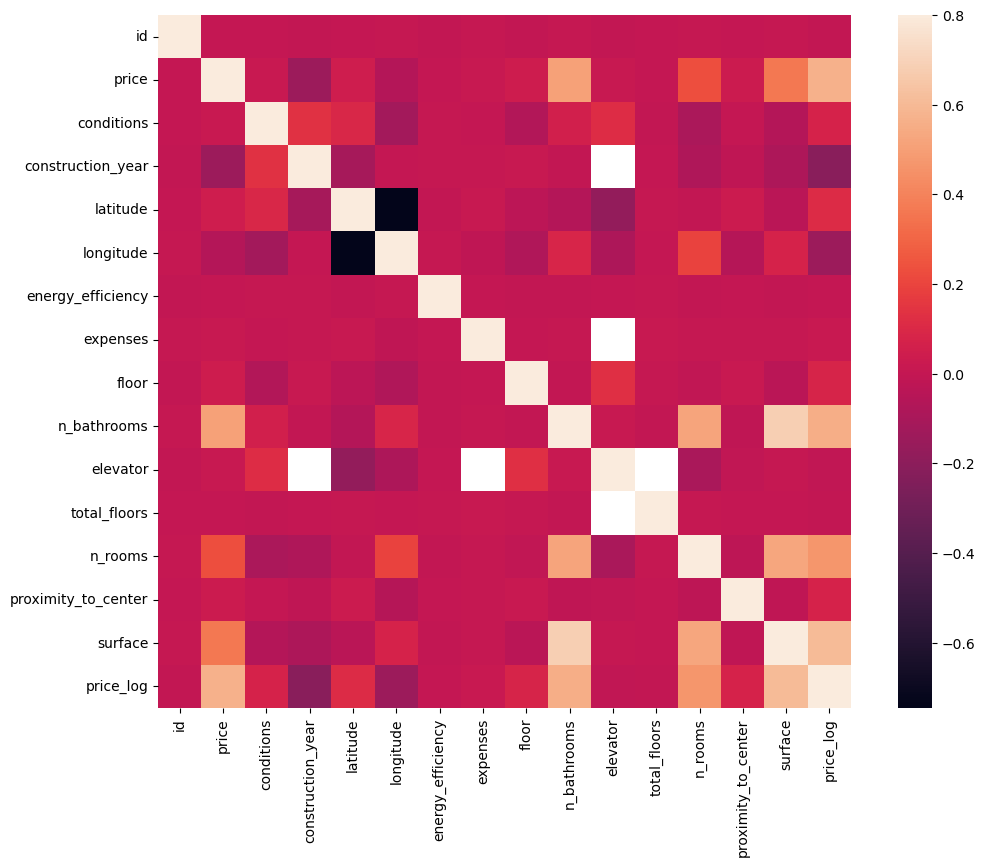

In [22]:
corrmat = (df_train.drop(columns=["garden", "balcony"])).corr() # we consider all variables except for garden and balcony
# having noticed that they only take "True" or nan so do not gives us any valuable information
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [23]:
df_train[df_train["elevator"]==0]

,id,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface,price_log
11,29022,1050000,1.0,1.0,NaN,45.435364,12.324397,999.00,NaN,2.0,NaN,2.0,0.0,NaN,5.0,1.0,135.0,13.864301
114,65125,680000,NaN,1.0,NaN,45.481865,9.183974,175.33,NaN,1.0,NaN,1.0,0.0,NaN,2.0,1.0,93.0,13.429848
130,61591,580000,NaN,1.0,NaN,45.436371,12.335354,NaN,NaN,2.0,NaN,2.0,0.0,NaN,5.0,1.0,100.0,13.270783
278,49413,1200000,1.0,1.0,NaN,45.438481,12.337059,NaN,NaN,3.0,NaN,3.0,0.0,NaN,6.0,1.0,150.0,13.997832
354,32680,290000,NaN,0.0,NaN,45.426860,12.325397,NaN,NaN,-1.0,NaN,1.0,0.0,NaN,2.0,1.0,55.0,12.577636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46228,60542,149000,NaN,1.0,NaN,41.881472,12.582349,175.00,NaN,-1.0,NaN,1.0,0.0,NaN,2.0,1.0,65.0,11.911702
46238,18520,600000,NaN,1.0,NaN,45.437310,12.320740,131.00,NaN,1.0,NaN,2.0,0.0,NaN,6.0,1.0,150.0,13.304685
46241,57706,350000,1.0,1.0,NaN,45.437644,12.329073,NaN,NaN,1.0,NaN,2.0,0.0,NaN,2.0,1.0,65.0,12.765688
46251,22854,285000,NaN,1.0,NaN,41.854734,12.549469,175.00,NaN,1.0,NaN,1.0,0.0,NaN,4.0,1.0,100.0,12.560244


Let's consider correlations between explanatory variables, which can help us determine the way we handle missing observations as well as the overall strategy for modelling the dependency between the price and house features.
1. We can observe that latitude and longitude are strongly negatively correlated. It is likely due to the shape of Italy as well as the particular cities selected. In general, Italy has land on the north-west and south-east, so if cities were chosen relatively uniformly, we would indeed have negative relationship between the longitude and the latitude. But this property may also be affected by the sample itself, the selection of particular cities, in which house prices and characteristics were gathered.
2. Construction year is strongly correlated with the presence of the elevator, meaning that for newer houses, the elevator is more prevalent. This makes sense.
3. Energy efficiency is rather uniformly distributed across different sets of characteristics.
4. Expenses are strongly correlated with the presence of the elevator.
5. Elevator is strongly correlated with the total number of floors, expenses as well as construction year.
6. Total number of floors is strongly correlated with the elevator.
7. Number of bathrooms are the most correlated with the surface and the number of rooms.
8. Number of rooms is strongly correlated with the surface and number of bathrooms.
9. Surface is strogly correlated with the number of rooms and the number of bathrooms.
10. The rest of explanatory variables does not have significant relationship with one another.

Let's now determine the 10 most correlated variables (in absolute terms) with the price of apartments.

In [24]:
price_corr_others=corrmat.loc[:, "price"].drop("price_log")
price_log_corr_others=corrmat.loc[:, "price_log"].drop("price")

Index(['price', 'n_bathrooms', 'surface', 'n_rooms', 'construction_year',
       'longitude', 'latitude', 'floor', 'proximity_to_center', 'conditions'],
      dtype='object')


<AxesSubplot:>

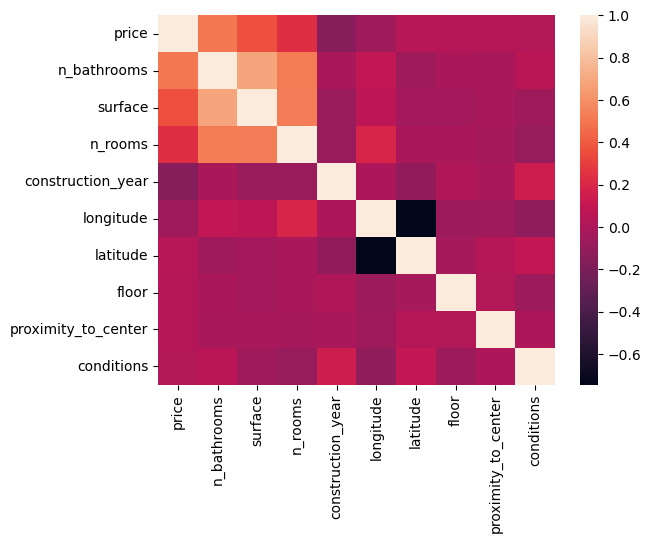

In [25]:
top_10_abs=price_corr_others.abs().nlargest(10).index # in absolute terms
print(top_10_abs) 
df_top_10_abs=df_train.loc[:, top_10_abs] #.drop(columns=["price_log"])
corrmat_top_10=df_top_10_abs.corr()
sns.heatmap(corrmat_top_10)

Index(['price_log', 'surface', 'n_bathrooms', 'n_rooms', 'construction_year',
       'longitude', 'latitude', 'floor', 'proximity_to_center', 'conditions'],
      dtype='object')


<AxesSubplot:>

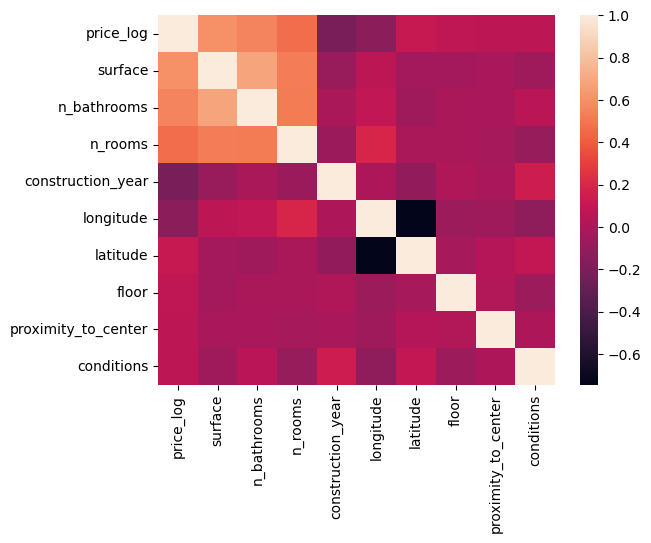

In [26]:
top_10_abs_log=price_log_corr_others.abs().nlargest(10).index # in absolute terms
print(top_10_abs_log) 
df_top_10_abs_log=df_train.loc[:, top_10_abs_log]
corrmat_top_10_log=df_top_10_abs_log.corr()
sns.heatmap(corrmat_top_10_log)

Price_log and price are the most correlated with the 10 variables shown on the above graphs. In the following, we will consider price_log as the dependent variable as its distribution approximately follows the normal, so applying this transformation would be beneficial for deriving a good model.

Price_log is significantly positively correlated with surface, number of bathrooms and number of rooms. It is negatively correlated with construction year. When it comes to other explanatory variables, the relationship is less pronounced.

## Additional explanatory variable - city and its population density 

Given variables latitude and longitude, which are not that directly related to the price of houses, we will consider adding additional explanatory variable, which may be able to capture more strongly the variation of house prices across different geographic areas. Using the data on latitude and longitude together with the dataset which contains data on latitudes and longitudes of specific cities as well as the dataset with data on the population densities of different cities, we will create an extra feature - population density. The reasoning behind is that the population density reflects to some extent the demand for houses in a specific city, although it can be limited by the architecture type and other considerations. However, I expect there to be some relationship which could explain the portion of house prices. This approach can suffer from overly small sample of cities present in the dataset.

To create a column "city" and fill it with data (name of the city which is the closest to the location of the house in terms of longitude and latitude), we will use the haversine formula. For each house in our dataframe, using coordinates in the longitude and latitude columns, we will calculate the distance between the house location and all cities in the dataframe mapping cities to geographical coordinates. Then, we will select the name of the city with the shortest distance to our house and assign its name to the corresponding row in the new "city" column in our df_train.

In [27]:
df_cities = pd.read_csv('cities.csv') # https://simplemaps.com/data/it-cities
df_pop_densities=pd.read_csv("pop_dens.csv") # data from 211, the smallest city with 57 k

In [28]:
df_cities

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Rome,41.8931,12.4828,Italy,IT,Lazio,primary,2872800,2872800
1,Milan,45.4669,9.1900,Italy,IT,Lombardy,admin,1366180,1366180
2,Naples,40.8333,14.2500,Italy,IT,Campania,admin,966144,966144
3,Turin,45.0667,7.7000,Italy,IT,Piedmont,admin,870952,870952
4,Palermo,38.1157,13.3613,Italy,IT,Sicilia,admin,668405,668405
...,...,...,...,...,...,...,...,...,...
3368,Sant’Eusanio del Sangro,42.1667,14.3333,Italy,IT,Abruzzo,NaN,2471,2471
3369,Cicagna,44.4085,9.2363,Italy,IT,Liguria,NaN,2470,2470
3370,Tollegno,45.5833,8.0500,Italy,IT,Piedmont,NaN,2469,2469
3371,Revere,45.0572,11.1302,Italy,IT,Lombardy,NaN,2468,2468


We define cities as above 100 000 (or 50 000).

In [29]:
df_cities.drop(df_cities[df_cities["population"]<150000].index, axis=0, inplace=True)
df_cities

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Rome,41.8931,12.4828,Italy,IT,Lazio,primary,2872800,2872800
1,Milan,45.4669,9.1900,Italy,IT,Lombardy,admin,1366180,1366180
2,Naples,40.8333,14.2500,Italy,IT,Campania,admin,966144,966144
3,Turin,45.0667,7.7000,Italy,IT,Piedmont,admin,870952,870952
4,Palermo,38.1157,13.3613,Italy,IT,Sicilia,admin,668405,668405
5,Genoa,44.4072,8.9340,Italy,IT,Liguria,admin,580097,580097
6,Bologna,44.4939,11.3428,Italy,IT,Emilia-Romagna,admin,389261,389261
7,Florence,43.7714,11.2542,Italy,IT,Tuscany,admin,380948,380948
8,Bari,41.1253,16.8667,Italy,IT,Puglia,admin,323370,323370
9,Catania,37.5027,15.0873,Italy,IT,Sicilia,minor,311584,311584


We have data on longitudes and latitudes of given cities. We need however a subset of these cities for several reasons. First and foremost, by investigating the data, I saw that observations with a larger distance from the city center often had the name of a small city (e.g. Fumicino for Rome or San Donato Milanese for Milan). I expect therefore, that they were considered by the data set provided to be still within the larger city, on its outskirts instead of in a new city. That is why it is worth it to restrict the possible set of the cities to be introduce. Moreover, I found data for 110 cities with their population densities and we want to consider densities directly for all cities without missing records (I could not get a dataset with population densities for all cities present in cities dataframe). Also we save computational time and make it more general. But the most importantly, it is how the original df_train dataset was constructed.

In [30]:
len(df_cities) # 3373 cities, very large number, which is probably not right classification (the one taken by creators of the original dataset)
# we will reduce the number of cities considered to 110, which are also the cities included in df_pop_densities dataframe

27

In [31]:
df_lat_lng_pop = pd.merge(df_cities[['city', 'lat', 'lng']], df_pop_densities[['city', 'population_density']], on='city', how='inner')

In [32]:
df_lat_lng_pop

,city,lat,lng,population_density
0,Rome,41.8931,12.4828,745.338966
1,Milan,45.4669,9.1900,1928.356787
2,Naples,40.8333,14.2500,2591.288024
3,Turin,45.0667,7.7000,329.248504
4,Palermo,38.1157,13.3613,248.256142
5,Genoa,44.4072,8.9340,466.702014
6,Bologna,44.4939,11.3428,263.684037
7,Florence,43.7714,11.2542,276.957914
8,Bari,41.1253,16.8667,322.894643
9,Catania,37.5027,15.0873,301.864007


A function computing the distance between points with coordinates.

In [33]:
def distance(lat1, lon1, lat2, lon2):
    # Convert the coordinates to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # Apply the haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = 6371 * c
    return distance

Now we will use this function to create a "city" column. #!!! maybe you can edit cities/ pop_dens dataset to include fewer cities after closer investigation, with population size up to... but then you need to filter by population_size and include pop_size there.

In [34]:
# Create a list to store the city names and pop_densities
city_names = []
pop_densities=[]

# Iterate over the rows in the df_train dataframe
for index, row in df_train.iterrows():
    # Get the coordinates of the current city
    lat2, lon2 = row['latitude'], row['longitude']
    if np.isnan(lat2) or np.isnan(lon2):
        city_names.append(np.nan)
        pop_densities.append(np.nan)
    else:
        # Calculate the distances to all cities in the cities_df dataframe
        distances = [(distance(lat1, lon1, lat2, lon2), name) for lat1, lon1, name in zip(df_lat_lng_pop['lat'], df_lat_lng_pop['lng'], df_lat_lng_pop['city'])]
    
        # Find the city with the shortest distance
        closest_city = min(distances)
        pop_density = df_lat_lng_pop.loc[df_lat_lng_pop["city"] == closest_city[1], "population_density"].values[0]
    
        # Add the name of the closest city to the city_names list
        city_names.append(closest_city[1])
        pop_densities.append(pop_density)
        

Finally, using the results, we can create new columns.

In [35]:
df_train["city"]=city_names
df_train["population_density"]=pop_densities

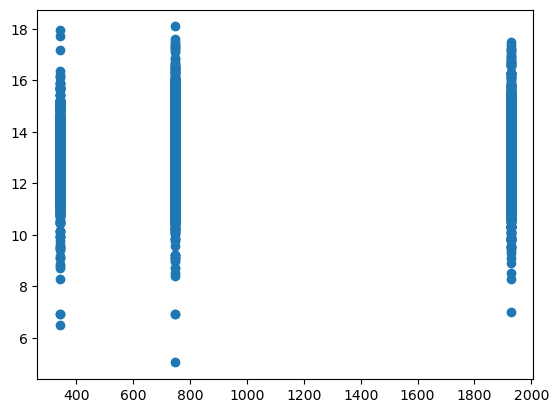

In [36]:
plt.scatter(df_train["population_density"], df_train["price_log"])

In [37]:
df_train["city"].value_counts()

Rome      24957
Milan     14077
Venice     7265
Name: city, dtype: int64

In [38]:
#df_train = df_train.drop(index=df_train[df_train["city"]=="Monza"].index)

In [39]:
from sklearn.preprocessing import OneHotEncoder

# Create an instance of the OneHotEncoder class
encoder = OneHotEncoder()

# Fit the encoder on the 'city' column in df_train
encoder.fit(df_train[['city']])

# Transform the 'city' column into one-hot encoded format
city_encoded = encoder.transform(df_train[['city']])

# Get the column names for the one-hot encoded features
column_names = encoder.get_feature_names(['city'])

# Create a new dataframe with the one-hot encoded features and concatenate it with df_train
df_train = pd.concat([df_train, pd.DataFrame(city_encoded.toarray(), columns=column_names)], axis=1)

In [40]:
df_train

,id,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,...,n_rooms,proximity_to_center,surface,price_log,city,population_density,city_Milan,city_Rome,city_Venice,city_nan
0,10461,60000,1.0,1.0,1980.0,41.901300,12.700000,175.00,30.0,2.0,...,1.0,1.00000,35.0,11.002100,Rome,745.338966,0.0,1.0,0.0,0.0
1,51304,900000,NaN,1.0,NaN,41.907017,12.481311,NaN,NaN,3.0,...,3.0,1.00000,131.0,13.710150,Rome,745.338966,0.0,1.0,0.0,0.0
2,33032,33000,NaN,1.0,1960.0,41.976500,12.440500,204.20,30.0,4.0,...,1.0,1.00000,16.0,10.404263,Rome,745.338966,0.0,1.0,0.0,0.0
3,62281,166000,NaN,2.0,NaN,45.484800,12.198200,175.00,NaN,1.0,...,2.0,0.99205,100.0,12.019743,Venice,342.496392,0.0,0.0,1.0,0.0
4,45681,410000,1.0,1.0,NaN,45.424480,12.328622,65.91,NaN,3.0,...,3.0,1.00000,90.0,12.923912,Venice,342.496392,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46307,33085,329999,1.0,1.0,1929.0,41.923500,12.446100,175.00,35.0,3.0,...,3.0,1.00000,88.0,12.706845,Rome,745.338966,0.0,1.0,0.0,0.0
46308,17403,599000,1.0,0.0,1920.0,41.916743,12.454925,NaN,170.0,6.0,...,5.0,1.00000,189.0,13.303017,Rome,745.338966,0.0,1.0,0.0,0.0
46309,33332,549000,1.0,1.0,NaN,45.454701,9.242711,NaN,NaN,NaN,...,3.0,1.00000,140.0,13.215854,Milan,1928.356787,1.0,0.0,0.0,0.0
46310,63367,189000,1.0,1.0,1965.0,45.445605,9.245942,NaN,150.0,-1.0,...,3.0,1.00000,70.0,12.149502,Milan,1928.356787,1.0,0.0,0.0,0.0


As we can see, in this dataset there is underrepresentation of cities Given the observations, I expect that Monza is considered Milan (distance from the center of the corresponding record is quite big) and Treviso is Venice. This way, we would get only 3 cities, also quite unique cities - one being a capital, another economic hub and another tourist destination with very unique architecture which would not for higher population density. Given that the data is not representative, we will disregard introducing population_density of the city as extra explanatory variable as we just have 3 cities, so sample is not enough and also cities considered are not average.

### Price distribution vs city

In [41]:
df_train[df_train["city"]=="Venice"]["price"].describe()

count    7.265000e+03
mean     4.575324e+05
std      1.131486e+06
min      6.500000e+02
25%      1.800000e+05
50%      3.200000e+05
75%      5.000000e+05
max      6.200000e+07
Name: price, dtype: float64

<AxesSubplot:xlabel='price_log', ylabel='Density'>

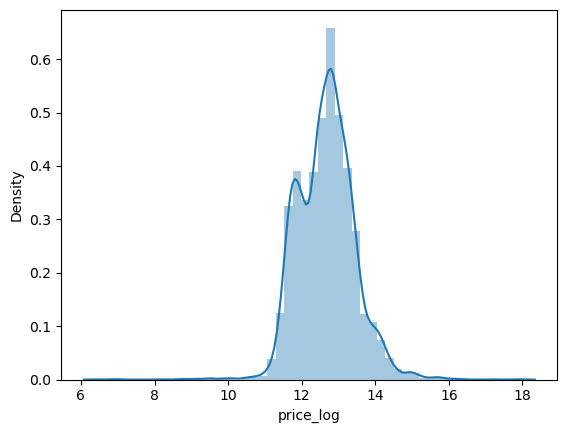

In [42]:
price_log_Venice=df_train[df_train["city"]=="Venice"]["price_log"]
sns.distplot(price_log_Venice)

In [43]:
df_train[df_train["city"]=="Rome"]["price"].describe()

count    2.495700e+04
mean     4.609747e+05
std      1.080419e+06
min      1.540000e+02
25%      1.898000e+05
50%      2.800000e+05
75%      4.490000e+05
max      7.200000e+07
Name: price, dtype: float64

<AxesSubplot:xlabel='price_log', ylabel='Density'>

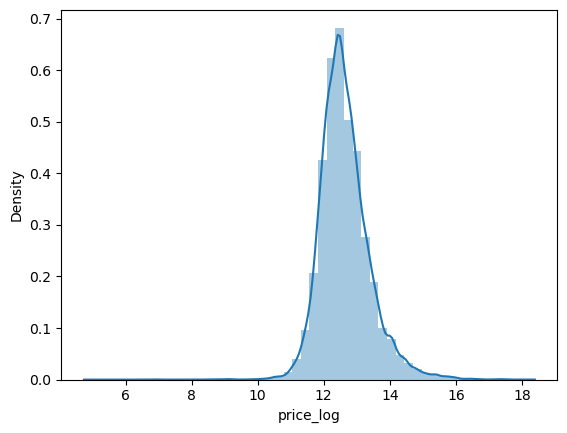

In [44]:
price_log_Rome=df_train[df_train["city"]=="Rome"]["price_log"]
sns.distplot(price_log_Rome)

In [45]:
df_train[df_train["city"]=="Milan"]["price"].describe()

count    1.407700e+04
mean     6.015218e+05
std      1.133130e+06
min      1.100000e+03
25%      2.400000e+05
50%      3.780000e+05
75%      6.500000e+05
max      4.000000e+07
Name: price, dtype: float64

<AxesSubplot:xlabel='price_log', ylabel='Density'>

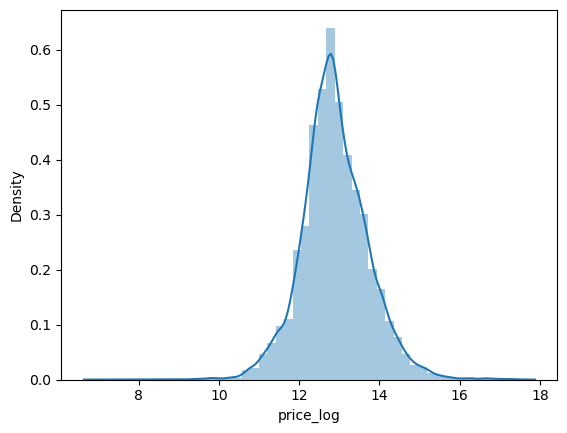

In [46]:
price_log_Milan=df_train[df_train["city"]=="Milan"]["price_log"]
sns.distplot(price_log_Milan)

Distribution of prices is different for all these 3 cities. Standard deviations are similar, but the mean is significantly greater for Milan. Also the other properties of the distribution are different so it makes sense to introduce the binary variable for the city name as the explanatory variable.

### Age of the building

It is connected to the construction_year so we will deal with construction year directly and this will take care of the age of the building as well, but maybe for learning the model, it would be better to use the age of the building, so we keep it for later.

In [47]:
df_train["age"] = np.nan  # create a new column "age" and initialize with NaNs
mask = ~df_train["construction_year"].isna()  # create a boolean mask for non-missing values of construction_year
df_train.loc[mask, "age"] = 2023 - df_train.loc[mask, "construction_year"]  # calculate age for non-missing values

## Dealing with missing data

To deal with the missing data, we will consider observations from the correlation heatmap and use other tools.

First, we will look into the major properties of the missing data to get an idea of the extent of issue, find out which features are primarily affected by this problem and come up with an approach for how to handle it. The following dataframe demonstrates the number and percentage of observations with a missing value for given features in the descending order.

In [48]:
df_missing=df_train.isna().sum().sort_values(ascending=False)
n_obs=df_train.shape[0]
df_missing_percentage=df_missing/n_obs
missing_data = pd.concat([df_missing, df_missing_percentage], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
garden,31529,0.680795
energy_efficiency,19903,0.429759
total_floors,18349,0.396204
elevator,17443,0.376641
expenses,16154,0.348808
balcony,15443,0.333456
age,13946,0.301131
construction_year,13946,0.301131
n_bathrooms,2416,0.052168
floor,2031,0.043855


### Garden

In [49]:
df_train["garden"].value_counts()

1.0    14783
Name: garden, dtype: int64

In the dataframe, there are only values "True" for the garden and the majority is nan. Let's investigate the price distribution of houses with garden and without to get more insights.

In [50]:
df_train["price"][df_train["garden"].isna()].describe()

count    3.152900e+04
mean     5.136783e+05
std      1.249632e+06
min      6.500000e+02
25%      1.972000e+05
50%      3.100000e+05
75%      5.200000e+05
max      7.200000e+07
Name: price, dtype: float64

In [51]:
df_train["price"][df_train["garden"]==True].describe()

count    1.478300e+04
mean     4.808140e+05
std      7.102384e+05
min      1.540000e+02
25%      2.122500e+05
50%      3.200000e+05
75%      5.000000e+05
max      3.000000e+07
Name: price, dtype: float64

These results do not give me much confidence to conclude about the missing values for gardens. The average price for houses with missing values for garden is slightly higher. However, although a garden adds value to the house, it is still possible that the missing values are False because there may be other variables which led to such a relationship. For example, there may be fewer houses with gardens in more expensive areas, where house prices are high.
Let's consider the distribution of "floor" variable for houses with garden and with missing records.

In [52]:
df_train["floor"][df_train["garden"].isna()].describe()

count    30228.000000
mean         2.147975
std          2.149929
min         -4.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: floor, dtype: float64

In [53]:
df_train["floor"][df_train["garden"]==True].describe()

count    14053.000000
mean         1.786736
std          2.210040
min         -5.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         26.000000
Name: floor, dtype: float64

We can observe that the mean, median and 1st quartile are lower for houses with gardens, which would be expected if "nan" was "False". Moreover, given that there is no "False" value in the column and that 68% observations are missing, we may assume that "nan" relates to "False". It would be surprising if we had more houses with gardens than without, considering the fact that the data relates to cities, which would imply bias. Given the percentage of missing values, we will not just drop the observations as this would lead us to lose a lot of data. We will instead replace "nan" with "False", which seems to be a reasonable strategy given the observations presented.

In [54]:
df_train["garden"][df_train["garden"].isna()]=0

In [55]:
df_train

,id,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,...,proximity_to_center,surface,price_log,city,population_density,city_Milan,city_Rome,city_Venice,city_nan,age
0,10461,60000,1.0,1.0,1980.0,41.901300,12.700000,175.00,30.0,2.0,...,1.00000,35.0,11.002100,Rome,745.338966,0.0,1.0,0.0,0.0,43.0
1,51304,900000,NaN,1.0,NaN,41.907017,12.481311,NaN,NaN,3.0,...,1.00000,131.0,13.710150,Rome,745.338966,0.0,1.0,0.0,0.0,NaN
2,33032,33000,NaN,1.0,1960.0,41.976500,12.440500,204.20,30.0,4.0,...,1.00000,16.0,10.404263,Rome,745.338966,0.0,1.0,0.0,0.0,63.0
3,62281,166000,NaN,2.0,NaN,45.484800,12.198200,175.00,NaN,1.0,...,0.99205,100.0,12.019743,Venice,342.496392,0.0,0.0,1.0,0.0,NaN
4,45681,410000,1.0,1.0,NaN,45.424480,12.328622,65.91,NaN,3.0,...,1.00000,90.0,12.923912,Venice,342.496392,0.0,0.0,1.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46307,33085,329999,1.0,1.0,1929.0,41.923500,12.446100,175.00,35.0,3.0,...,1.00000,88.0,12.706845,Rome,745.338966,0.0,1.0,0.0,0.0,94.0
46308,17403,599000,1.0,0.0,1920.0,41.916743,12.454925,NaN,170.0,6.0,...,1.00000,189.0,13.303017,Rome,745.338966,0.0,1.0,0.0,0.0,103.0
46309,33332,549000,1.0,1.0,NaN,45.454701,9.242711,NaN,NaN,NaN,...,1.00000,140.0,13.215854,Milan,1928.356787,1.0,0.0,0.0,0.0,NaN
46310,63367,189000,1.0,1.0,1965.0,45.445605,9.245942,NaN,150.0,-1.0,...,1.00000,70.0,12.149502,Milan,1928.356787,1.0,0.0,0.0,0.0,58.0


### Balcony

In [56]:
df_train["balcony"].describe()

count    30869.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: balcony, dtype: float64

In [57]:
df_train["floor"][df_train["balcony"].isna()].describe()

count    14309.000000
mean         1.477881
std          2.163958
min         -3.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         56.000000
Name: floor, dtype: float64

In [58]:
df_train["floor"][df_train["balcony"]==True].describe()

count    29972.000000
mean         2.298512
std          2.130805
min         -5.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         26.000000
Name: floor, dtype: float64

Mean floor is higher when balcony is True.

We will treat the missing values for the feature "balcony" in the similar way. Given that there is only "True" value present, we will assume that "nan" relates to "False".

In [59]:
df_train["balcony"][df_train["balcony"].isna()]=0

### Missing geographical data

We can observe that we have the same number of missing observations for the following explanatory variables: latitude, longitude, proximity_to_center, city and population_density. Given that they are related and the same number of observation is missing, we expect that the missing valeus refer to the same observations. We will verify this to confirm.

In [60]:
missing_geography=df_train.loc[df_train['proximity_to_center'].isna() | df_train['latitude'].isna() | df_train['longitude'].isna()]
print(len(missing_geography))

13


It is indeed the case. These 13 missing observations constitute a small proportion of the total observations, so we can freely drop them without losing much information.

In [61]:
df_train = df_train.dropna(subset=['proximity_to_center', 'latitude', 'longitude'])

### Size of the house

Now we take care of the physical characteristics of the house, which reflect its size: surface area, number of bathrooms and number of rooms. As outlined before, these variables are correlated so we will consider them jointly.

When it comes to surface and n_rooms, less than 1% of data is missing so we will drop the corresponding observations. With regard to the number of bathrooms, we will try to estimate it from the corresponding value of the surface area and the number of rooms. Essentially, we will approach this problem of missing observations with the educated guess.

In [62]:
# First, let's drop the observations with missing data on surface or the number of rooms (or both)
df_train.drop(df_train[df_train["surface"].isna() | df_train["n_rooms"].isna()].index, axis=0, inplace=True)

### Outliers

We will handle outliers relative to these 3 features already here in order to be able to build a good model for predicting the number of bathrooms based on the number of rooms and the surface. Considering that the surface area, number of rooms and number of bathrooms should be related, we will first take care of outliers. We will consider the ratio between 3 pairs: n_rooms and n_bathrooms, n_rooms and surface as well as surface and n_bathrooms.

In [63]:
#mask1=(df_train["n_rooms"].isna() | df_train["n_bathrooms"].isna())
#mask2=(df_train["surface"].isna() | df_train["n_bathrooms"].isna())
#mask3=(df_train["n_rooms"].isna() | df_train["surface"].isna())
mask=df_train["n_bathrooms"].isna()
n_rooms=df_train["n_rooms"][~mask]
n_bathrooms=df_train["n_bathrooms"][~mask]
surface=df_train["surface"][~mask]

#### Ratio n_rooms to n_bathrooms

In [64]:
n_rooms_n_bathrooms=n_rooms/n_bathrooms
n_rooms_n_bathrooms.describe()

count    43464.000000
mean         2.272331
std          0.902379
min          0.111111
25%          1.666667
50%          2.000000
75%          3.000000
max          9.000000
dtype: float64

In [65]:
# calculate the interquartile range (IQR) for the n_rooms_n_bathrooms (ratio of these quantities)
Q1 = n_rooms_n_bathrooms.quantile(0.25)
Q3 = n_rooms_n_bathrooms.quantile(0.75)
IQR = Q3 - Q1

# calculate the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# identify outliers
outliers = n_rooms_n_bathrooms[(n_rooms_n_bathrooms < lower_bound) | (n_rooms_n_bathrooms > upper_bound)]

# print the outliers
print(outliers)

485      6.0
1238     6.0
1265     6.0
1357     6.0
1683     7.0
        ... 
45199    6.0
45455    6.0
45472    6.0
45726    8.0
46280    6.0
Length: 184, dtype: float64


In [66]:
# Only a few outliers, we can delete them. We have anomalies with 61.258 value
#df_train.drop(df_train[~mask & ((df_train["n_rooms"]/ df_train["n_bathrooms"])<lower_bound) | ((df_train["n_rooms"]/ df_train["n_bathrooms"])>upper_bound)].index, axis=0, inplace=True)

In [67]:
df_train

,id,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,...,proximity_to_center,surface,price_log,city,population_density,city_Milan,city_Rome,city_Venice,city_nan,age
0,10461,60000,1.0,1.0,1980.0,41.901300,12.700000,175.00,30.0,2.0,...,1.00000,35.0,11.002100,Rome,745.338966,0.0,1.0,0.0,0.0,43.0
1,51304,900000,0.0,1.0,NaN,41.907017,12.481311,NaN,NaN,3.0,...,1.00000,131.0,13.710150,Rome,745.338966,0.0,1.0,0.0,0.0,NaN
2,33032,33000,0.0,1.0,1960.0,41.976500,12.440500,204.20,30.0,4.0,...,1.00000,16.0,10.404263,Rome,745.338966,0.0,1.0,0.0,0.0,63.0
3,62281,166000,0.0,2.0,NaN,45.484800,12.198200,175.00,NaN,1.0,...,0.99205,100.0,12.019743,Venice,342.496392,0.0,0.0,1.0,0.0,NaN
4,45681,410000,1.0,1.0,NaN,45.424480,12.328622,65.91,NaN,3.0,...,1.00000,90.0,12.923912,Venice,342.496392,0.0,0.0,1.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46307,33085,329999,1.0,1.0,1929.0,41.923500,12.446100,175.00,35.0,3.0,...,1.00000,88.0,12.706845,Rome,745.338966,0.0,1.0,0.0,0.0,94.0
46308,17403,599000,1.0,0.0,1920.0,41.916743,12.454925,NaN,170.0,6.0,...,1.00000,189.0,13.303017,Rome,745.338966,0.0,1.0,0.0,0.0,103.0
46309,33332,549000,1.0,1.0,NaN,45.454701,9.242711,NaN,NaN,NaN,...,1.00000,140.0,13.215854,Milan,1928.356787,1.0,0.0,0.0,0.0,NaN
46310,63367,189000,1.0,1.0,1965.0,45.445605,9.245942,NaN,150.0,-1.0,...,1.00000,70.0,12.149502,Milan,1928.356787,1.0,0.0,0.0,0.0,58.0


#### Ratio surface to n_bathrooms

In [68]:
surface_n_bathrooms=surface/n_bathrooms
surface_n_bathrooms.describe()

count    43464.000000
mean        70.321927
std         30.698047
min          0.000000
25%         51.000000
50%         65.000000
75%         83.000000
max        820.000000
dtype: float64

In [69]:
Q1 = surface_n_bathrooms.quantile(0.25)
Q3 = surface_n_bathrooms.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR # larger variation allowed so we in
upper_bound = Q3 + 1.5 * IQR

outliers = surface_n_bathrooms[(surface_n_bathrooms < lower_bound) | (surface_n_bathrooms > upper_bound)]

print(outliers)

57       140.0
63       150.0
87       143.0
164      265.0
170      170.0
         ...  
46110    140.0
46117    172.0
46195    195.0
46252    135.0
46296    145.0
Length: 1089, dtype: float64


In [70]:
lower_bound

3.0

In [71]:
# Not many outliers, we can delete them. 
#df_train.drop(df_train[~mask & ((df_train["surface"]/ df_train["n_bathrooms"])<lower_bound) | ((df_train["surface"]/ df_train["n_bathrooms"])>upper_bound)].index, axis=0, inplace=True)

In [72]:
df_train

,id,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,...,proximity_to_center,surface,price_log,city,population_density,city_Milan,city_Rome,city_Venice,city_nan,age
0,10461,60000,1.0,1.0,1980.0,41.901300,12.700000,175.00,30.0,2.0,...,1.00000,35.0,11.002100,Rome,745.338966,0.0,1.0,0.0,0.0,43.0
1,51304,900000,0.0,1.0,NaN,41.907017,12.481311,NaN,NaN,3.0,...,1.00000,131.0,13.710150,Rome,745.338966,0.0,1.0,0.0,0.0,NaN
2,33032,33000,0.0,1.0,1960.0,41.976500,12.440500,204.20,30.0,4.0,...,1.00000,16.0,10.404263,Rome,745.338966,0.0,1.0,0.0,0.0,63.0
3,62281,166000,0.0,2.0,NaN,45.484800,12.198200,175.00,NaN,1.0,...,0.99205,100.0,12.019743,Venice,342.496392,0.0,0.0,1.0,0.0,NaN
4,45681,410000,1.0,1.0,NaN,45.424480,12.328622,65.91,NaN,3.0,...,1.00000,90.0,12.923912,Venice,342.496392,0.0,0.0,1.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46307,33085,329999,1.0,1.0,1929.0,41.923500,12.446100,175.00,35.0,3.0,...,1.00000,88.0,12.706845,Rome,745.338966,0.0,1.0,0.0,0.0,94.0
46308,17403,599000,1.0,0.0,1920.0,41.916743,12.454925,NaN,170.0,6.0,...,1.00000,189.0,13.303017,Rome,745.338966,0.0,1.0,0.0,0.0,103.0
46309,33332,549000,1.0,1.0,NaN,45.454701,9.242711,NaN,NaN,NaN,...,1.00000,140.0,13.215854,Milan,1928.356787,1.0,0.0,0.0,0.0,NaN
46310,63367,189000,1.0,1.0,1965.0,45.445605,9.245942,NaN,150.0,-1.0,...,1.00000,70.0,12.149502,Milan,1928.356787,1.0,0.0,0.0,0.0,58.0


#### Surface vs n_rooms

In [73]:
surface_n_rooms=surface/n_rooms
surface_n_rooms.describe()

count    43464.000000
mean        35.094998
std         37.620576
min          0.000000
25%         25.250000
50%         30.000000
75%         36.000000
max        990.000000
dtype: float64

In [74]:
Q1 = surface_n_rooms.quantile(0.25)
Q3 = surface_n_rooms.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 2.5 * IQR # given the properties of the ratio, we allow for higher variability (we also do not want to discard
# too many data points)
upper_bound = Q3 + 2.5 * IQR

outliers = surface_n_rooms[(surface_n_rooms < lower_bound) | (surface_n_rooms > upper_bound)]

print(outliers) 

78        66.000000
111       65.000000
164      106.000000
183      105.000000
229      550.000000
            ...    
45899     73.333333
45967    389.000000
46001     85.000000
46070    353.000000
46266     65.000000
Length: 1087, dtype: float64


In [75]:
#df_train.drop(df_train[((df_train["surface"]/ df_train["n_rooms"])<lower_bound) | ((df_train["surface"]/ df_train["n_rooms"])>upper_bound)].index, axis=0, inplace=True)

In [76]:
df_train

,id,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,...,proximity_to_center,surface,price_log,city,population_density,city_Milan,city_Rome,city_Venice,city_nan,age
0,10461,60000,1.0,1.0,1980.0,41.901300,12.700000,175.00,30.0,2.0,...,1.00000,35.0,11.002100,Rome,745.338966,0.0,1.0,0.0,0.0,43.0
1,51304,900000,0.0,1.0,NaN,41.907017,12.481311,NaN,NaN,3.0,...,1.00000,131.0,13.710150,Rome,745.338966,0.0,1.0,0.0,0.0,NaN
2,33032,33000,0.0,1.0,1960.0,41.976500,12.440500,204.20,30.0,4.0,...,1.00000,16.0,10.404263,Rome,745.338966,0.0,1.0,0.0,0.0,63.0
3,62281,166000,0.0,2.0,NaN,45.484800,12.198200,175.00,NaN,1.0,...,0.99205,100.0,12.019743,Venice,342.496392,0.0,0.0,1.0,0.0,NaN
4,45681,410000,1.0,1.0,NaN,45.424480,12.328622,65.91,NaN,3.0,...,1.00000,90.0,12.923912,Venice,342.496392,0.0,0.0,1.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46307,33085,329999,1.0,1.0,1929.0,41.923500,12.446100,175.00,35.0,3.0,...,1.00000,88.0,12.706845,Rome,745.338966,0.0,1.0,0.0,0.0,94.0
46308,17403,599000,1.0,0.0,1920.0,41.916743,12.454925,NaN,170.0,6.0,...,1.00000,189.0,13.303017,Rome,745.338966,0.0,1.0,0.0,0.0,103.0
46309,33332,549000,1.0,1.0,NaN,45.454701,9.242711,NaN,NaN,NaN,...,1.00000,140.0,13.215854,Milan,1928.356787,1.0,0.0,0.0,0.0,NaN
46310,63367,189000,1.0,1.0,1965.0,45.445605,9.245942,NaN,150.0,-1.0,...,1.00000,70.0,12.149502,Milan,1928.356787,1.0,0.0,0.0,0.0,58.0


#### Outliers in the individual data 

We first took approach of identifying outliers based on their IQR, but this approach was not robust for our problem.

##### N_bathrooms

In [77]:
df_train["n_bathrooms"].describe()
# possible numbers so for now we leave it as it is

count    43464.000000
mean         1.557634
std          0.771111
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          9.000000
Name: n_bathrooms, dtype: float64

In [78]:
df_train["n_bathrooms"].quantile(0.99)
df_train[df_train["n_bathrooms"]>4]

,id,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,...,proximity_to_center,surface,price_log,city,population_density,city_Milan,city_Rome,city_Venice,city_nan,age
229,9577,1380000,1.0,1.0,2009.0,42.023975,12.359469,NaN,170.0,3.0,...,1.0,550.0,14.137594,Rome,745.338966,0.0,1.0,0.0,0.0,14.0
237,3490,1830000,1.0,3.0,1970.0,41.994703,12.455172,NaN,NaN,NaN,...,1.0,0.0,14.419827,Rome,745.338966,0.0,1.0,0.0,0.0,53.0
310,21863,2580000,1.0,1.0,NaN,41.873815,12.463680,175.0,NaN,4.0,...,1.0,400.0,14.763300,Rome,745.338966,0.0,1.0,0.0,0.0,NaN
334,64501,1400000,1.0,1.0,NaN,45.430599,12.331328,NaN,NaN,3.0,...,1.0,210.0,14.151983,Venice,342.496392,0.0,0.0,1.0,0.0,NaN
682,42303,4200000,1.0,3.0,1900.0,45.456082,9.214538,NaN,NaN,NaN,...,1.0,550.0,15.250595,Milan,1928.356787,1.0,0.0,0.0,0.0,123.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45547,45729,2400000,1.0,1.0,NaN,41.924239,12.477645,NaN,NaN,3.0,...,1.0,500.0,14.690979,Rome,745.338966,0.0,1.0,0.0,0.0,NaN
45559,22083,1950000,1.0,1.0,NaN,45.426874,12.338640,NaN,NaN,-1.0,...,1.0,375.0,14.483340,Venice,342.496392,0.0,0.0,1.0,0.0,NaN
45710,29771,1099000,1.0,3.0,1600.0,41.900510,12.466557,NaN,80.0,2.0,...,1.0,250.0,13.909911,Rome,745.338966,0.0,1.0,0.0,0.0,423.0
45846,51523,2100000,0.0,1.0,NaN,42.014335,12.538076,175.0,NaN,2.0,...,1.0,800.0,14.557448,Rome,745.338966,0.0,1.0,0.0,0.0,NaN


In [79]:
Q1 = df_train['n_bathrooms'].quantile(0.25)
Q3 = df_train['n_bathrooms'].quantile(0.75)
IQR = Q3 - Q1

# calculate the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# identify outliers in the construction_year variable
outliers = df_train[(df_train['n_bathrooms'] < lower_bound) | (df_train['n_bathrooms'] > upper_bound)]

# print the outliers
print(outliers)

          id    price  balcony  conditions  construction_year   latitude  \
102    19792  7000000      1.0         1.0             1800.0  45.468217   
229     9577  1380000      1.0         1.0             2009.0  42.023975   
237     3490  1830000      1.0         3.0             1970.0  41.994703   
310    21863  2580000      1.0         1.0                NaN  41.873815   
334    64501  1400000      1.0         1.0                NaN  45.430599   
...      ...      ...      ...         ...                ...        ...   
45967  12028   382500      0.0         1.0                NaN  41.736373   
46004  58361   550000      0.0         3.0                NaN  45.436064   
46070  28205   620000      1.0         1.0             1980.0  42.019478   
46108   9575  3500000      1.0         3.0             1800.0  45.440343   
46268   6063  1490000      1.0         1.0                NaN  45.490356   

       longitude  energy_efficiency  expenses  floor  ...  \
102     9.204108          

In [80]:
#df_train.drop(df_train[(df_train["n_bathrooms"] < lower_bound) | (df_train["n_bathrooms"] > upper_bound)].index, inplace=True)

##### Surface

In [81]:
# 370 is likely for a big aparment/ house, but 0 not, we will discard surface areas below 15
df_train[df_train["surface"]<15]

,id,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,...,proximity_to_center,surface,price_log,city,population_density,city_Milan,city_Rome,city_Venice,city_nan,age
237,3490,1830000,1.0,3.0,1970.0,41.994703,12.455172,NaN,NaN,NaN,...,1.0,0.0,14.419827,Rome,745.338966,0.0,1.0,0.0,0.0,53.0
374,50426,18750,0.0,1.0,NaN,45.461500,9.224868,NaN,NaN,NaN,...,1.0,11.0,9.838949,Milan,1928.356787,1.0,0.0,0.0,0.0,NaN
385,54158,1600000,1.0,1.0,1950.0,42.023894,12.359742,NaN,NaN,NaN,...,1.0,0.0,14.285514,Rome,745.338966,0.0,1.0,0.0,0.0,73.0
569,10175,5900000,1.0,1.0,NaN,45.498300,9.201700,159.62,0.0,0.0,...,1.0,0.0,15.590463,Milan,1928.356787,1.0,0.0,0.0,0.0,NaN
1528,41551,8200000,0.0,2.0,NaN,41.904301,12.487744,175.00,NaN,4.0,...,1.0,0.0,15.919645,Rome,745.338966,0.0,1.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44360,62170,6100000,0.0,0.0,NaN,45.452900,9.223680,NaN,0.0,NaN,...,1.0,0.0,15.623799,Milan,1928.356787,1.0,0.0,0.0,0.0,NaN
45069,8058,13500000,0.0,0.0,1990.0,41.916908,12.498440,1.00,NaN,0.0,...,1.0,0.0,16.418200,Rome,745.338966,0.0,1.0,0.0,0.0,33.0
45198,58012,11000000,1.0,1.0,NaN,41.918598,12.478500,1.00,NaN,0.0,...,1.0,0.0,16.213406,Rome,745.338966,0.0,1.0,0.0,0.0,NaN
45820,26087,295000,0.0,1.0,NaN,41.886760,12.676639,NaN,NaN,2.0,...,1.0,0.0,12.594731,Rome,745.338966,0.0,1.0,0.0,0.0,NaN


In [82]:
df_train.drop(df_train[(df_train["surface"] < 15)].index, inplace=True) # surface below 15 is hardly possible so we will drop these observations

##### N_rooms

In [83]:
df_train["n_rooms"].describe()

count    45400.000000
mean         3.283789
std          1.329780
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          9.000000
Name: n_rooms, dtype: float64

#### Regression to fill the missing values for n_bathrooms

In [84]:
df_physical=df_train[["n_bathrooms", "surface", "n_rooms"]]
df_physical

,n_bathrooms,surface,n_rooms
0,1.0,35.0,1.0
1,1.0,131.0,3.0
2,1.0,16.0,1.0
3,1.0,100.0,2.0
4,2.0,90.0,3.0
...,...,...,...
46307,1.0,88.0,3.0
46308,2.0,189.0,5.0
46309,2.0,140.0,3.0
46310,1.0,70.0,3.0


In [85]:
sum(df_train["n_bathrooms"].isna())

1981

Now we drop the rows for which n_bathrooms is missing. Using df_physical data, we will use it to get training and test sets to learn a model for n_bathrooms given surface and n_rooms.

In [86]:
df_physical.drop(df_physical[df_physical["n_bathrooms"].isna()].index, axis=0, inplace=True)
df_physical=df_physical.reset_index(drop=True)
df_physical

,n_bathrooms,surface,n_rooms
0,1.0,35.0,1.0
1,1.0,131.0,3.0
2,1.0,16.0,1.0
3,1.0,100.0,2.0
4,2.0,90.0,3.0
...,...,...,...
43414,1.0,88.0,3.0
43415,2.0,189.0,5.0
43416,2.0,140.0,3.0
43417,1.0,70.0,3.0


Text(0, 0.5, 'Number of houses')

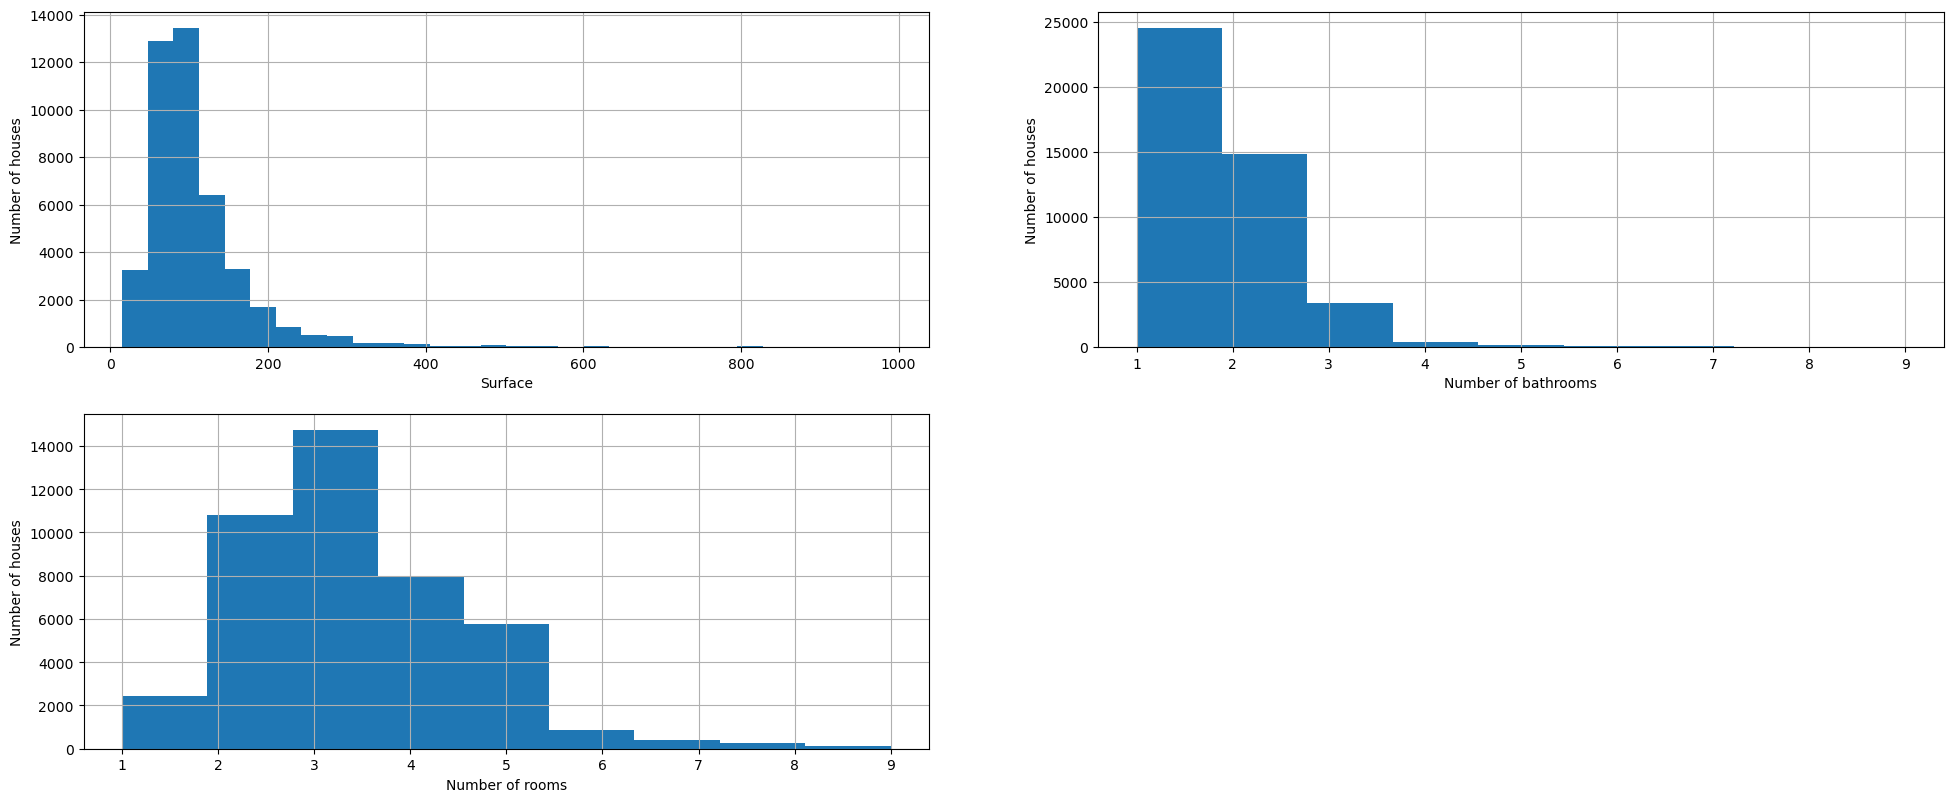

In [87]:
plt.figure(figsize=(24,20))


plt.subplot(4, 2, 1)
fig = df_physical['surface'].hist(bins=30)
fig.set_xlabel('Surface')
fig.set_ylabel('Number of houses')


plt.subplot(4, 2, 2)
fig = df_physical['n_bathrooms'].hist(bins=df_physical['n_bathrooms'].nunique())
fig.set_xlabel("Number of bathrooms")
fig.set_ylabel('Number of houses')


plt.subplot(4, 2, 3)
fig = df_physical['n_rooms'].hist(bins=df_physical['n_rooms'].nunique())
fig.set_xlabel('Number of rooms')
fig.set_ylabel('Number of houses')

Given that data on the number of bathrooms is right-skewed, we will apply the logarithmic transformation to it.

In [88]:
df_physical['n_bathrooms_log']=np.log(df_physical['n_bathrooms'])

Text(0, 0.5, 'Number of houses')

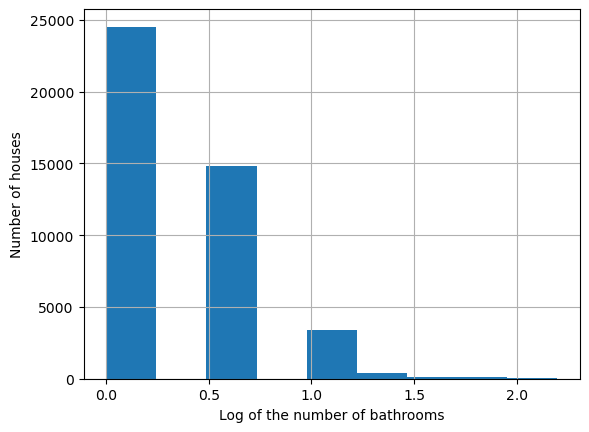

In [89]:
plt.figure()
fig = df_physical['n_bathrooms_log'].hist(bins=df_physical['n_bathrooms_log'].nunique())
fig.set_xlabel('Log of the number of bathrooms')
fig.set_ylabel('Number of houses')

Given the correlation, we will use linear regression to model the relationship between X and y. We will use the k-fold cross-validation technique to improve the performance and limit overfitting. Moreover, we will apply the model both to log of the number of bathrooms and the number of bathrooms and compare the predictions. We will try using standardized data relative to the number of bathrooms and not standardized. We will standardize the data relative to the surface area and the number of rooms, given that their scales differ significantly.

First, we create instances of standard scaler. Then we get a matrix of scaled observations corresponding to explanatory variables, the scaled vector of observations relative to the target variable and the scaled vector of the logarithm of the observations relative to the target variable. We will run a linear regression with cross-vallidation on different combinations of X_scaled with y, y_log, y_scaled and y_log_scaled.

Let's take care of the outliers first. We already defined outliers and discarded but we can do so with a few more data points.

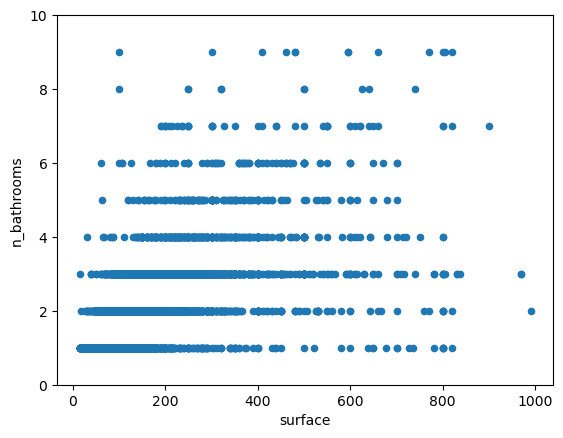

In [90]:
var = 'surface'
data = pd.concat([df_physical['n_bathrooms'], df_physical[var]], axis=1)
data.plot.scatter(x=var, y='n_bathrooms', ylim=(0,10));

In [91]:
df_train.shape

(45400, 25)

In [92]:
df_physical.drop(df_physical.loc[((df_physical["n_bathrooms"]==5) | (df_physical["n_bathrooms"]==6)) & (df_physical["surface"]<150)].index, inplace=True)
df_physical.drop(df_physical.loc[((df_physical["n_bathrooms"]==8) | (df_physical["n_bathrooms"]==9)) & (df_physical["surface"]<200)].index, inplace=True)

In [93]:
df_train.drop(df_train.loc[((df_train["n_bathrooms"]==5) | (df_train["n_bathrooms"]==6)) & (df_train["surface"]<150)].index, inplace=True)
df_train.drop(df_train.loc[((df_train["n_bathrooms"]==8) | (df_train["n_bathrooms"]==9)) & (df_train["surface"]<200)].index, inplace=True)

In [94]:
df_train.shape

(45387, 25)

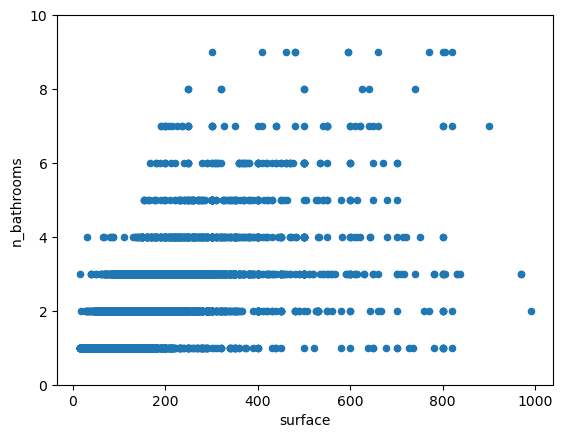

In [97]:
# After handling the remaining outliers

var = 'surface'
data = pd.concat([df_physical['n_bathrooms'], df_physical[var]], axis=1)
data.plot.scatter(x=var, y='n_bathrooms', ylim=(0,10));


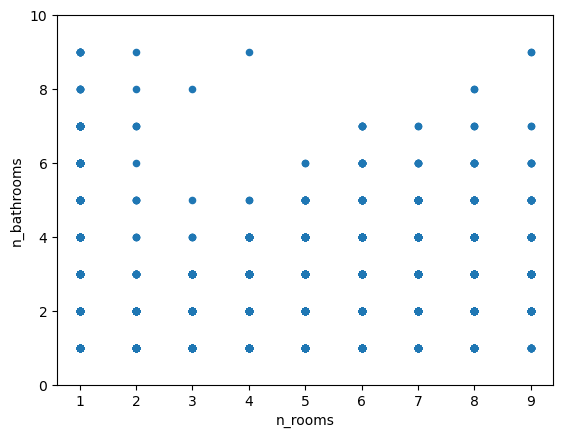

In [98]:
var = 'n_rooms'
data = pd.concat([df_physical['n_bathrooms'], df_physical[var]], axis=1)
data.plot.scatter(x=var, y='n_bathrooms', ylim=(0,10));

In [99]:
df_train

,id,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,...,proximity_to_center,surface,price_log,city,population_density,city_Milan,city_Rome,city_Venice,city_nan,age
0,10461,60000,1.0,1.0,1980.0,41.901300,12.700000,175.00,30.0,2.0,...,1.00000,35.0,11.002100,Rome,745.338966,0.0,1.0,0.0,0.0,43.0
1,51304,900000,0.0,1.0,NaN,41.907017,12.481311,NaN,NaN,3.0,...,1.00000,131.0,13.710150,Rome,745.338966,0.0,1.0,0.0,0.0,NaN
2,33032,33000,0.0,1.0,1960.0,41.976500,12.440500,204.20,30.0,4.0,...,1.00000,16.0,10.404263,Rome,745.338966,0.0,1.0,0.0,0.0,63.0
3,62281,166000,0.0,2.0,NaN,45.484800,12.198200,175.00,NaN,1.0,...,0.99205,100.0,12.019743,Venice,342.496392,0.0,0.0,1.0,0.0,NaN
4,45681,410000,1.0,1.0,NaN,45.424480,12.328622,65.91,NaN,3.0,...,1.00000,90.0,12.923912,Venice,342.496392,0.0,0.0,1.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46307,33085,329999,1.0,1.0,1929.0,41.923500,12.446100,175.00,35.0,3.0,...,1.00000,88.0,12.706845,Rome,745.338966,0.0,1.0,0.0,0.0,94.0
46308,17403,599000,1.0,0.0,1920.0,41.916743,12.454925,NaN,170.0,6.0,...,1.00000,189.0,13.303017,Rome,745.338966,0.0,1.0,0.0,0.0,103.0
46309,33332,549000,1.0,1.0,NaN,45.454701,9.242711,NaN,NaN,NaN,...,1.00000,140.0,13.215854,Milan,1928.356787,1.0,0.0,0.0,0.0,NaN
46310,63367,189000,1.0,1.0,1965.0,45.445605,9.245942,NaN,150.0,-1.0,...,1.00000,70.0,12.149502,Milan,1928.356787,1.0,0.0,0.0,0.0,58.0


In [100]:
#df_physical.drop(df_physical.loc[(df_physical["n_bathrooms"]==6) & (df_physical["n_rooms"]==1)].index, inplace=True)
#df_train.drop(df_train.loc[(df_train["n_bathrooms"]==6) & (df_train["n_rooms"]==1)].index, inplace=True)

df_train.drop(df_train[df_train["n_bathrooms"]>df_train["n_rooms"]].index, inplace=True)
df_physical.drop(df_physical[df_physical["n_bathrooms"]>df_physical["n_rooms"]].index, inplace=True)

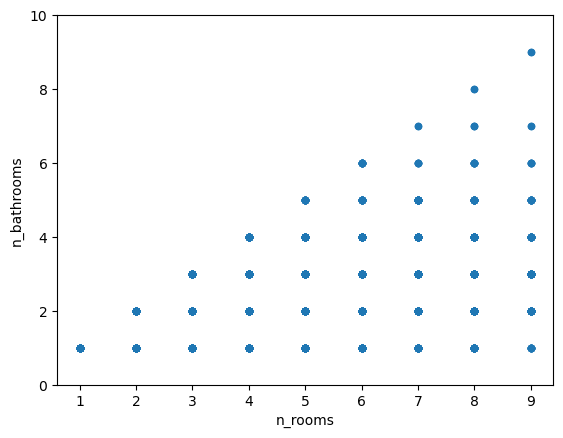

In [102]:

var = 'n_rooms'
data = pd.concat([df_physical['n_bathrooms'], df_physical[var]], axis=1)
data.plot.scatter(x=var, y='n_bathrooms', ylim=(0,10));

Here we drop missing n_rooms and surface but for filling test data, we will use the models of n_rooms against surface and surface against n_rooms
MODEL_N_ROOMS, MODEL_SURFACE

Mean Squared Error: 0.3618988857417313
R-squared: 0.6401988900470047


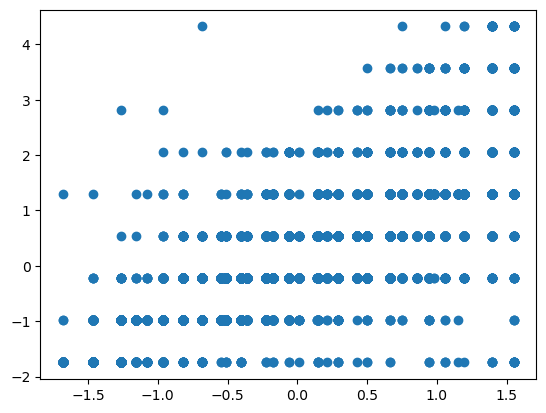

In [103]:
mask_tr=(df_train["surface"].isna() | df_train["n_rooms"].isna())

x=df_train["surface"][~mask_tr]
y=df_train["n_rooms"][~mask_tr]

scaler__1=StandardScaler()
scaler__2=StandardScaler()

# Scaling
x_scaled=scaler__1.fit_transform(x[:,np.newaxis])
y_scaled=scaler__2.fit_transform(y[:,np.newaxis])

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.3, random_state=9)

# create the decision tree model
model_n_rooms = DecisionTreeRegressor(max_depth=5)

# train the model
model_n_rooms.fit(X_train, y_train)

# make predictions on the testing set
y_pred = model_n_rooms.predict(X_test)
plt.scatter(y_pred, y_test)

# calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print the results
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.36716786550936037
R-squared: 0.6359159924496132


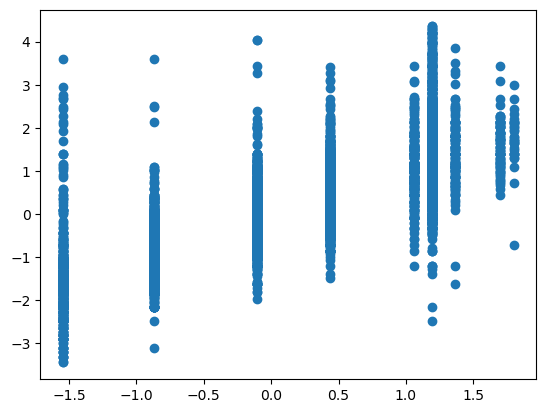

In [104]:
y=df_train["surface"][~mask_tr]
x=df_train["n_rooms"][~mask_tr]
y[y!=0]=np.log(y)

scaler__3=StandardScaler()
scaler__4=StandardScaler()

# Scaling
x_scaled=scaler__3.fit_transform(x[:,np.newaxis])
y_scaled=scaler__4.fit_transform(y[:,np.newaxis])

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.3, random_state=9)

# create the decision tree model
model_surface = DecisionTreeRegressor(max_depth=5)

# train the model
model_surface.fit(X_train, y_train)

# make predictions on the testing set
y_pred = model_surface.predict(X_test)
plt.scatter(y_pred, y_test)

# calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print the results
print("Mean Squared Error:", mse)
print("R-squared:", r2)

## Model for bathroooms

In [105]:
scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()
#X = scaler.fit_transform(X)

X=df_physical[['surface', 'n_rooms']] # explanatory variables
cols = X.columns
y=df_physical['n_bathrooms'] # target variables
y_log=df_physical['n_bathrooms_log'] # log of target variables

# Scaling
X_scaled=scaler1.fit_transform(X)
y_scaled=scaler2.fit_transform(y[:,np.newaxis])
y_log_scaled=scaler3.fit_transform(y_log[:,np.newaxis])

# we will use y_log or y_log_scaled

##### X_scaled and y

In [106]:
'''
# Polynomial features
poly = PolynomialFeatures(degree=2)
X_scaled = poly.fit_transform(X_scaled)

model = LinearRegression() 
kfold = KFold(5) # 5-fold, the split is default
errors = []
r2s = []
for train_indices, test_indices in kfold.split(X_scaled): 
    model.fit(X_scaled[train_indices, :], y[train_indices])
    predictions = model.predict(X_scaled[test_indices, :])
    #plt.scatter(predictions, y[test_indices]) 
    error = mean_squared_error(y[test_indices], predictions)
    errors.append(error)
    r2 = model.score(X_scaled[test_indices, :], y[test_indices])
    r2s.append(r2)
print(np.sqrt(np.mean(errors)))
print(r2s)
print(model.coef_)
'''

'\n# Polynomial features\npoly = PolynomialFeatures(degree=2)\nX_scaled = poly.fit_transform(X_scaled)\n\nmodel = LinearRegression() \nkfold = KFold(5) # 5-fold, the split is default\nerrors = []\nr2s = []\nfor train_indices, test_indices in kfold.split(X_scaled): \n    model.fit(X_scaled[train_indices, :], y[train_indices])\n    predictions = model.predict(X_scaled[test_indices, :])\n    #plt.scatter(predictions, y[test_indices]) \n    error = mean_squared_error(y[test_indices], predictions)\n    errors.append(error)\n    r2 = model.score(X_scaled[test_indices, :], y[test_indices])\n    r2s.append(r2)\nprint(np.sqrt(np.mean(errors)))\nprint(r2s)\nprint(model.coef_)\n'

##### X_scaled and y_log

In [107]:
'''
# Polynomial features
poly = PolynomialFeatures(degree=2)
X_scaled = poly.fit_transform(X_scaled)

model = LinearRegression() 
kfold = KFold(5) # 5-fold, the split is default
errors = []
r2s = []
for train_indices, test_indices in kfold.split(X_scaled): 
    model.fit(X_scaled[train_indices, :], y_log[train_indices])
    predictions = model.predict(X_scaled[test_indices, :])
    #plt.scatter(predictions, y_log[test_indices]) 
    error = mean_squared_error(y_log[test_indices], predictions)
    errors.append(error)
    r2 = model.score(X_scaled[test_indices, :], y_log[test_indices])
    r2s.append(r2)
print(np.sqrt(np.mean(errors)))
print(r2s)
print(model.coef_)
'''

'\n# Polynomial features\npoly = PolynomialFeatures(degree=2)\nX_scaled = poly.fit_transform(X_scaled)\n\nmodel = LinearRegression() \nkfold = KFold(5) # 5-fold, the split is default\nerrors = []\nr2s = []\nfor train_indices, test_indices in kfold.split(X_scaled): \n    model.fit(X_scaled[train_indices, :], y_log[train_indices])\n    predictions = model.predict(X_scaled[test_indices, :])\n    #plt.scatter(predictions, y_log[test_indices]) \n    error = mean_squared_error(y_log[test_indices], predictions)\n    errors.append(error)\n    r2 = model.score(X_scaled[test_indices, :], y_log[test_indices])\n    r2s.append(r2)\nprint(np.sqrt(np.mean(errors)))\nprint(r2s)\nprint(model.coef_)\n'

##### X_scaled and y_scaled

In [108]:
# Polynomial features
poly = PolynomialFeatures(degree=2)
X_scaled_pol = poly.fit_transform(X_scaled)

model_1 = LinearRegression() 
kfold = KFold(5) # 5-fold, the split is default
errors = []
errors_actual=[] ###
r2s = []
y_actual=np.exp(scaler3.inverse_transform(y_scaled)) ###
for train_indices, test_indices in kfold.split(X_scaled_pol): 
    model_1.fit(X_scaled_pol[train_indices, :], y_scaled[train_indices])
    predictions = model_1.predict(X_scaled_pol[test_indices, :])
    predictions_actual= np.exp(scaler3.inverse_transform(predictions)) ###
    #plt.scatter(predictions, y_scaled[test_indices]) 
    error = mean_squared_error(y_scaled[test_indices], predictions)
    # ACTUAL ERRORS: ###
    error_actual=mean_squared_error(y_actual[test_indices], predictions) ###
    errors.append(error)
    errors_actual.append(error_actual)
    r2 = model_1.score(X_scaled_pol[test_indices, :], y_scaled[test_indices])
    r2s.append(r2)
print(np.sqrt(np.mean(errors)))
print(r2s)
print(model_1.coef_)
print(np.sqrt(np.mean(errors_actual)))

0.6737735124050792
[0.5478172897492826, 0.5470521692285064, 0.5406804883382053, 0.5454815850703758, 0.5493167900515006]
[[ 0.          0.68597519  0.18738116 -0.06895138  0.10739894 -0.03105634]]
1.929855821201551


##### X_scaled and y_log_scaled

0.6882581874427428
[0.5302992606666385, 0.5271597391835339, 0.5238978490880571, 0.5242468955833188, 0.5258699029204815]
[[ 0.          0.70635762  0.21288577 -0.0701923   0.04574847 -0.03866107]]


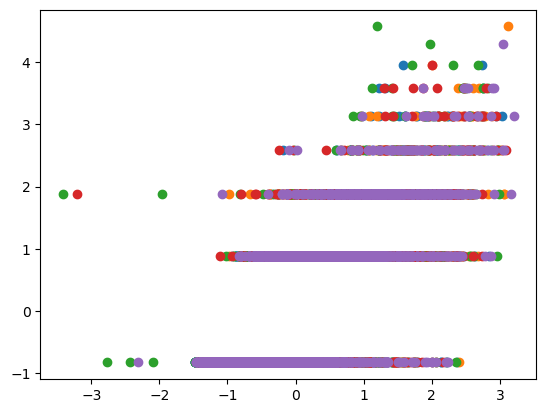

In [109]:
# 0.67!! 

poly = PolynomialFeatures(degree=2)
X_scaled_pol = poly.fit_transform(X_scaled)

model_2 = LinearRegression() 
kfold = KFold(5) # 5-fold, the split is default
errors = []
r2s = []
for train_indices, test_indices in kfold.split(X_scaled_pol): 
    model_2.fit(X_scaled_pol[train_indices, :], y_log_scaled[train_indices])
    predictions = model_2.predict(X_scaled_pol[test_indices, :])
    plt.scatter(predictions, y_log_scaled[test_indices]) 
    error = mean_squared_error(y_log_scaled[test_indices], predictions)
    errors.append(error)
    r2 = model_2.score(X_scaled_pol[test_indices, :], y_log_scaled[test_indices])
    r2s.append(r2)
print(np.sqrt(np.mean(errors)))
print(r2s)
print(model_2.coef_)

# R

In [110]:
'''
scaler = StandardScaler()
scaled_surface = scaler.fit_transform(df_physical["surface"][:, np.newaxis])
plt.scatter(scaled_surface, y_log_scaled)
'''

'\nscaler = StandardScaler()\nscaled_surface = scaler.fit_transform(df_physical["surface"][:, np.newaxis])\nplt.scatter(scaled_surface, y_log_scaled)\n'

In [111]:
'''
scaler = StandardScaler()
scaled_n_rooms = scaler.fit_transform(df_physical["n_rooms"][:, np.newaxis])
plt.scatter(scaled_n_rooms, y_log_scaled)
'''

'\nscaler = StandardScaler()\nscaled_n_rooms = scaler.fit_transform(df_physical["n_rooms"][:, np.newaxis])\nplt.scatter(scaled_n_rooms, y_log_scaled)\n'

Results for adding polynomial features of degree 2:
    1.
    2.

We will use the model learned by training on X_scaled and y_log_scaled with quadratic features and following coefficients: 0., 0.80336258, 0.15695012, -0.07623839, -0.01547043, 0.00406651.

Or try with decision tree regressor.

In [112]:
# We do not want polynomial features for Decision Tree regressor.
# DID I HANDLE THE OUTLIERS

'''
scaler_1=StandardScaler()
scaler_2=StandardScaler()
scaler_3=StandardScaler()

# Scaling
X_scaled=scaler_1.fit_transform(X)
y_scaled=scaler_2.fit_transform(y[:,np.newaxis])
y_log_scaled=scaler_3.fit_transform(y_log[:,np.newaxis])
'''

'\nscaler_1=StandardScaler()\nscaler_2=StandardScaler()\nscaler_3=StandardScaler()\n\n# Scaling\nX_scaled=scaler_1.fit_transform(X)\ny_scaled=scaler_2.fit_transform(y[:,np.newaxis])\ny_log_scaled=scaler_3.fit_transform(y_log[:,np.newaxis])\n'

In [113]:
'''
poly = PolynomialFeatures(degree=2)
X_scaled_pol = poly.fit_transform(X_scaled)

model_2 = LinearRegression() 
kfold = KFold(5) # 5-fold, the split is default
errors = []
r2s = []
for train_indices, test_indices in kfold.split(X_scaled_pol): 
    model_2.fit(X_scaled_pol[train_indices, :], y_log_scaled[train_indices])
    predictions = model_2.predict(X_scaled_pol[test_indices, :])
    plt.scatter(predictions, y_log_scaled[test_indices]) 
    error = mean_squared_error(y_log_scaled[test_indices], predictions)
    errors.append(error)
    r2 = model_2.score(X_scaled_pol[test_indices, :], y_log_scaled[test_indices])
    r2s.append(r2)
print(np.sqrt(np.mean(errors)))
print(r2s)
print(model_2.coef_)

##### continue thing above later

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_log_scaled, test_size=0.3, random_state=9)

# create the decision tree model
model_3 = DecisionTreeRegressor(max_depth=5)

# train the model
model_3.fit(X_train, y_train)

# make predictions on the testing set
y_pred = model_3.predict(X_test)
plt.scatter(y_pred, y_test)

# calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print the results
print("Mean Squared Error:", mse)
print("R-squared:", r2)
'''

'\npoly = PolynomialFeatures(degree=2)\nX_scaled_pol = poly.fit_transform(X_scaled)\n\nmodel_2 = LinearRegression() \nkfold = KFold(5) # 5-fold, the split is default\nerrors = []\nr2s = []\nfor train_indices, test_indices in kfold.split(X_scaled_pol): \n    model_2.fit(X_scaled_pol[train_indices, :], y_log_scaled[train_indices])\n    predictions = model_2.predict(X_scaled_pol[test_indices, :])\n    plt.scatter(predictions, y_log_scaled[test_indices]) \n    error = mean_squared_error(y_log_scaled[test_indices], predictions)\n    errors.append(error)\n    r2 = model_2.score(X_scaled_pol[test_indices, :], y_log_scaled[test_indices])\n    r2s.append(r2)\nprint(np.sqrt(np.mean(errors)))\nprint(r2s)\nprint(model_2.coef_)\n\n##### continue thing above later\n\n# split into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X_scaled, y_log_scaled, test_size=0.3, random_state=9)\n\n# create the decision tree model\nmodel_3 = DecisionTreeRegressor(max_depth=5)\n\n# tr

With decision tree, we got R-squared of 0.609 for predicting the number of bathrooms. We decided to apply X_scaled and y_scaled, so both features and target variables were scaled using standard scaler.

In [114]:
# Hyperparameter tuning for the random forest

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# Define the parameter grid
param_dist = {
    'n_estimators': [350, 400, 500],
    'max_depth': [2, 5, 10, 20]
}

# Create the random forest model
model_4 = RandomForestRegressor()

# Define the search strategy
n_iter_search = 20
random_search = RandomizedSearchCV(
    model_4,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    cv=5,
    random_state=9,
    n_jobs=-1
)

# Fit the model to the data
random_search.fit(X_scaled, y_log_scaled)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'n_estimators': 400, 'max_depth': 10}


Mean Squared Error: 0.4483313782022949
R-squared: 0.5519573792139343


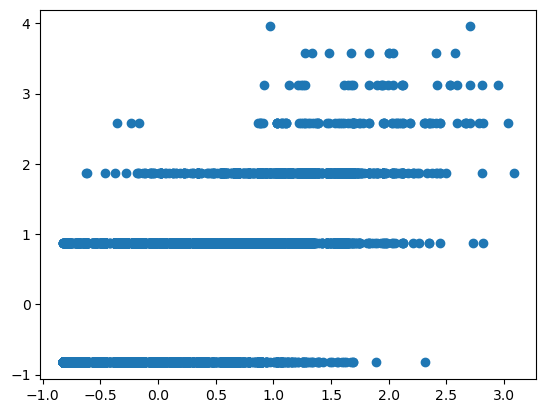

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_log_scaled, test_size=0.3, random_state=9)

# create the Random Forest model
model_5 = RandomForestRegressor(n_estimators=400, max_depth=10, random_state=9)

model_5.fit(X_train, y_train)

y_pred = model_5.predict(X_test)
plt.scatter(y_pred, y_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

In [116]:
model_bathrooms=model_5 # seems the best based on MSE, and we applied regression on y_log_scaled in all cases

In [117]:
sum(df_train['n_bathrooms'].isna())

1981

Having trained the model and selected random forest, we can predict missing values.

In [118]:
# Select rows with missing values in n_bathrooms column

###poly = PolynomialFeatures(degree=2)

mask = df_train['n_bathrooms'].isna()
# Scale the features using the same scaler object as before
X_scaled = scaler1.transform(df_train.loc[mask, ['surface', 'n_rooms']])

###X_scaled_pol = poly.fit_transform(X_scaled)

# Make predictions for the missing values
###predictions_scaled_log = model_bathrooms.predict(X_scaled_pol)
predictions_scaled_log = model_bathrooms.predict(X_scaled)

# Invert the scaling of the predictions
predictions_log = scaler3.inverse_transform(np.array(predictions_scaled_log[:, np.newaxis]))

predictions=np.exp(predictions_log)

# Fill in the missing values with the predictions
df_train.loc[mask, 'n_bathrooms'] = predictions

# Verify that the missing values have been filled in
print(df_train['n_bathrooms'].isna().sum())  # should output 0

0


In [119]:
df_train["n_bathrooms"].describe()

count    44987.000000
mean         1.558908
std          0.711094
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          9.000000
Name: n_bathrooms, dtype: float64

In [120]:
#df_train[~mask] # we will keep the number of bathrooms as not integer, it is estimation anyways
# we will leave n_bathrooms as a non-integer value, as this retains the additional information provided by the regression

##### Energy efficiency

In [121]:
df_train["energy_efficiency"].describe()

count    2.583200e+04
mean     5.189667e+03
std      7.684919e+05
min      1.000000e-02
25%      1.610000e+02
50%      1.750000e+02
75%      1.750000e+02
max      1.234570e+08
Name: energy_efficiency, dtype: float64

Energy efficiency has huge standard deviation, more than 100 times bigger than the mean, so there is a big uncertainty associated with that variable. Also from the analysis of the correlation matrix as a heat map, we did not see significant correlation with other variables, which makes it even harder to estimate this variable. Moreover, it has 43% of the observations missing, which reduces even more its informative value. It is also not very correlated with the price. Due to these several considerations, we decide to drop it. It is likely a better stategy than trying to estimate its missing values. Also empirically, these characteristics do not seem to have a strong causal relation with the price.

In [122]:
df_train.drop('energy_efficiency', axis=1, inplace=True)

##### Expenses

In [123]:
df_train["expenses"].describe() # similar reasoning applies as for energy efficiency

count     29879.000000
mean        189.850129
std        3948.395761
min           0.000000
25%          40.000000
50%          80.000000
75%         150.000000
max      346000.000000
Name: expenses, dtype: float64

In [124]:
df_train.drop('expenses', axis=1, inplace=True)

##### Total floors

In [125]:
df_train["total_floors"].describe() # similar reasoning as for expenses and energy efficiency

count    27308.000000
mean         5.731727
std        193.392587
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max      31960.000000
Name: total_floors, dtype: float64

In [126]:
df_train.drop('total_floors', axis=1, inplace=True)

##### Elevator

Reasoning before noting limited availability of data (not relevant anymore): Due to very strong correlation of the elevator with the expenses and the construction year, and given that it is binary variable, we will use logistic regression to predict its value based on the values corresponding to total_floors, expenses and construction_year. We will consider several models to be able to estimate also using 2 or 1 variable if others are missing. First we discard the observations for which all 4 columns have missing values.

In [127]:
#df_train.drop(df_train[(df_train["total_floors"].isna() & df_train["expenses"].isna() & df_train["construction_year"].isna()) & df_train["elevator"].isna()].index, inplace=True)

In [128]:
df_train["elevator"].value_counts()

1.0    27160
0.0     1350
Name: elevator, dtype: int64

Given that we have 20 times more apartments with elevator, we will use mode imputation strategy, which gives us a significant level of confidence.

In [129]:
#df_train[(df_train["total_floors"].isna() & df_train["expenses"].isna() & df_train["construction_year"].isna()) & df_train["elevator"].isna()]

Case 1 - values for total floors, expenses and construction year are available.

In [130]:
'''
# Case 1
mask = (df_train["total_floors"].isna()) | (df_train["expenses"].isna()) | (df_train["construction_year"].isna()) | (df_train["elevator"].isna())
df_exp_floor_constr = df_train.loc[~mask, ["elevator", "expenses", "total_floors", "construction_year"]]
df_exp_floor_constr["elevator"].value_counts()
'''

'\n# Case 1\nmask = (df_train["total_floors"].isna()) | (df_train["expenses"].isna()) | (df_train["construction_year"].isna()) | (df_train["elevator"].isna())\ndf_exp_floor_constr = df_train.loc[~mask, ["elevator", "expenses", "total_floors", "construction_year"]]\ndf_exp_floor_constr["elevator"].value_counts()\n'

Only one class available so not enough data to fit the model.

In [131]:
'''
# Case 2
mask = (df_train["expenses"].isna()) | (df_train["construction_year"].isna()) | (df_train["elevator"].isna())
df_exp_constr = df_train.loc[~mask, ["elevator", "expenses", "construction_year"]]
df_exp_constr["elevator"].value_counts()
'''

'\n# Case 2\nmask = (df_train["expenses"].isna()) | (df_train["construction_year"].isna()) | (df_train["elevator"].isna())\ndf_exp_constr = df_train.loc[~mask, ["elevator", "expenses", "construction_year"]]\ndf_exp_constr["elevator"].value_counts()\n'

In [132]:
'''
# Case 3
mask = (df_train["total_floors"].isna()) | (df_train["construction_year"].isna()) | (df_train["elevator"].isna())
df_floor_constr = df_train.loc[~mask, ["elevator", "total_floors", "construction_year"]]
df_floor_constr["elevator"].value_counts()
'''

'\n# Case 3\nmask = (df_train["total_floors"].isna()) | (df_train["construction_year"].isna()) | (df_train["elevator"].isna())\ndf_floor_constr = df_train.loc[~mask, ["elevator", "total_floors", "construction_year"]]\ndf_floor_constr["elevator"].value_counts()\n'

In [133]:
'''
# Case 4
mask = (df_train["total_floors"].isna()) | (df_train["expenses"].isna()) | (df_train["elevator"].isna())
df_exp_floor = df_train.loc[~mask, ["elevator", "expenses", "total_floors"]]
df_exp_floor["elevator"].value_counts()
'''

'\n# Case 4\nmask = (df_train["total_floors"].isna()) | (df_train["expenses"].isna()) | (df_train["elevator"].isna())\ndf_exp_floor = df_train.loc[~mask, ["elevator", "expenses", "total_floors"]]\ndf_exp_floor["elevator"].value_counts()\n'

In [134]:
'''
# Case 5
mask = (df_train["total_floors"].isna()) | (df_train["elevator"].isna())
df_floor = df_train.loc[~mask, ["elevator", "total_floors"]]
df_floor["elevator"].value_counts()
'''

'\n# Case 5\nmask = (df_train["total_floors"].isna()) | (df_train["elevator"].isna())\ndf_floor = df_train.loc[~mask, ["elevator", "total_floors"]]\ndf_floor["elevator"].value_counts()\n'

In [135]:
'''
# Case 6
mask = (df_train["construction_year"].isna()) | (df_train["elevator"].isna())
df_constr = df_train.loc[~mask, ["elevator", "construction_year"]]
df_constr["elevator"].value_counts()
'''

'\n# Case 6\nmask = (df_train["construction_year"].isna()) | (df_train["elevator"].isna())\ndf_constr = df_train.loc[~mask, ["elevator", "construction_year"]]\ndf_constr["elevator"].value_counts()\n'

In [136]:
'''
# Case 7
mask = (df_train["expenses"].isna()) | (df_train["elevator"].isna())
df_exp = df_train.loc[~mask, ["expenses", "elevator"]]
df_exp["elevator"].value_counts()
'''

'\n# Case 7\nmask = (df_train["expenses"].isna()) | (df_train["elevator"].isna())\ndf_exp = df_train.loc[~mask, ["expenses", "elevator"]]\ndf_exp["elevator"].value_counts()\n'

In [137]:
# df_train[(df_train["elevator"]==0) & ~(df_train["construction_year"].isna() & df_train["expenses"].isna() & df_train["total_floors"].isna())]

So actually the high correlation between the elevator and the number of floors, expenses and construction year is due to the fact that we have only 1 for the elevator when the rest is given.

In [138]:
# Checking if we deleted everything
#df_exp_floor_constr[(df_exp_floor_constr["total_floors"].isna()) | (df_exp_floor_constr["expenses"].isna()) | (df_exp_floor_constr["construction_year"].isna()) | (df_exp_floor_constr["elevator"].isna())]

In [139]:
df_train["elevator"].value_counts()

1.0    27160
0.0     1350
Name: elevator, dtype: int64

Since it is not possible to estimate value for elevator based on the variables which could potentially be correlated with it (number of floors and construction year in particular, expenses were not that justified anyways), because elevator takes only value 1 when other variables take some known values, we will use imputation technique, specifying "mode" as a strategy. But before we do it, we wil consider other variables and try to guess them using educated guess, before we artifically fill the elevator, so that the values filled by us using imputter are not considered while estimating other variables.

In [140]:
'''
# Let's check if variables correlated with the elevator are such because of unavailability of data.
print((df_train[df_train["elevator"]==0]["construction_year"]).value_counts(),
(df_train[df_train["elevator"]==0]["expenses"]).value_counts(),
(df_train[df_train["elevator"]==0]["total_floors"]).value_counts())
# For all these variables, we have no data when elevator is 0. So we will disregard elevator variable from estimating them.
'''

'\n# Let\'s check if variables correlated with the elevator are such because of unavailability of data.\nprint((df_train[df_train["elevator"]==0]["construction_year"]).value_counts(),\n(df_train[df_train["elevator"]==0]["expenses"]).value_counts(),\n(df_train[df_train["elevator"]==0]["total_floors"]).value_counts())\n# For all these variables, we have no data when elevator is 0. So we will disregard elevator variable from estimating them.\n'

We can freely take care of elevator, filling it using imputter with median. The percentage of missing observations is too large to drop these observations. We also use imputter for the remaining variables with missing observations as they are not significantly correlated with any other explanatory variables (as concluded by examining the correlation heatmap at the beginning) and if the heatmap suggested some level of correlation, it was due to underrepresentation of certain kinds of data as just established. Therefore, imputting using median and mean strategies, depending on the variable, appear to be a sound strategy given that there is limited availability of relevant data). Moreover, it is important to note that the variables whose missing values we will be filling are not as correlated with the price so imputting their values should not have a drastic effect on the performance of the model. It helps to keep other observations with values for more critical variables which will help us learn a better model. While training the model, we will later consider whether it makes sense to drop specific variables, especially the ones which had a lot of missing observations and which seem rather redundant (or at least not that significant) for explaining the house prices.

We will see if there is a significant correlation between the population density and any other variable with missing observations to check one lat time if we can learn the missing data using a better strategy.

In [141]:
corrmat2 = (df_train.drop(columns=["garden", "balcony"])).corr() 
pop_density_corr_others=corrmat2.loc["population_density", :] # how population density helps to explain other explanatory variables
pop_density_corr_others # it does not help us significantly in explaining the remaining variables so we will use imputation techniques

id                    -0.002784
price                  0.086075
conditions             0.109611
construction_year      0.042215
latitude               0.535607
longitude             -0.960409
floor                  0.104616
n_bathrooms           -0.083360
elevator               0.180093
n_rooms               -0.256914
proximity_to_center    0.080437
surface               -0.080112
price_log              0.150801
population_density     1.000000
city_Milan             0.972711
city_Rome             -0.533556
city_Venice           -0.502953
city_nan                    NaN
age                   -0.042215
Name: population_density, dtype: float64

There is no significant correlation except for the variables longitude and latitude which we already dealt with. So now we will focus on imputing strategy.

In [142]:
from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+

##### Elevator

In [143]:
df_train["elevator"].value_counts()

1.0    27160
0.0     1350
Name: elevator, dtype: int64

Elevator is a categorical variable with a big dominance of one class (1.0), so we will use the mode imputation strategy.

##### Energy efficiency

In [144]:
# sns.distplot(df_train['energy_efficiency'])

In [145]:
# df_train["energy_efficiency"].describe()

For energy efficiency we will use the median imputation strategy. The distribution of energy efficiency is highly skewed with a very large standard deviation, and the maximum value is significantly larger than the other values in the dataset. This implies that the data may contain extreme outliers that could significantly influence the mean value.

##### Total floors

In [146]:
# sns.distplot(df_train['total_floors'])

In [147]:
# df_train["total_floors"].describe() 

31960? A lot of outliers, which we will take care of and take the median imputation strategy as of now.

##### Expenses

In [148]:
# sns.distplot(df_train['expenses'])

In [149]:
# df_train["expenses"].describe() 

Again the distribution is highly skewed with a lot of outliers, so we use median.

##### Construction year

In [150]:
corr_coeff1 = df_train['price_log'].corr(df_train['construction_year'])
corr_coeff2 = df_train['price'].corr(df_train['construction_year'])
print(corr_coeff1, corr_coeff2)

-0.20941540477812678 -0.17160982956137652


Construction year is the 4th most correlated variable with price_log, so it is important for explaining the house prices. At the same time there is no reliable data to be able to learn the missing values for construction year to fill them in. However, we want to avoid bias which could appear if we just dropped 1/4 of the observations so in order to avoid this, we will use median inputation strategy.

<AxesSubplot:xlabel='construction_year', ylabel='Density'>

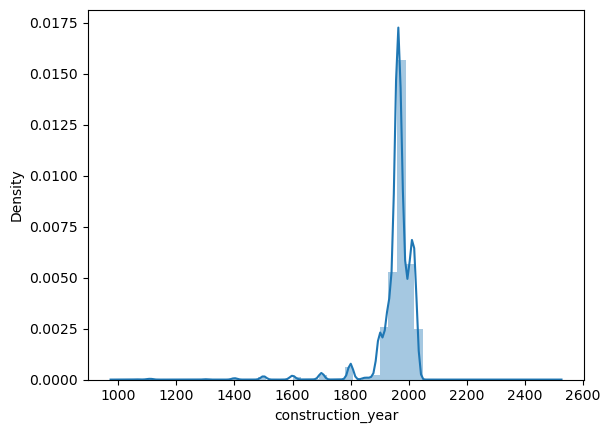

In [151]:
sns.distplot(df_train['construction_year'])

In [152]:
df_train["construction_year"].describe() 

count    31951.000000
mean      1958.052831
std         71.890552
min       1000.000000
25%       1950.000000
50%       1966.000000
75%       1987.000000
max       2500.000000
Name: construction_year, dtype: float64

Data is approximately normally distributed. We will impute mean for the missing values.

##### Floor

<AxesSubplot:xlabel='floor', ylabel='Density'>

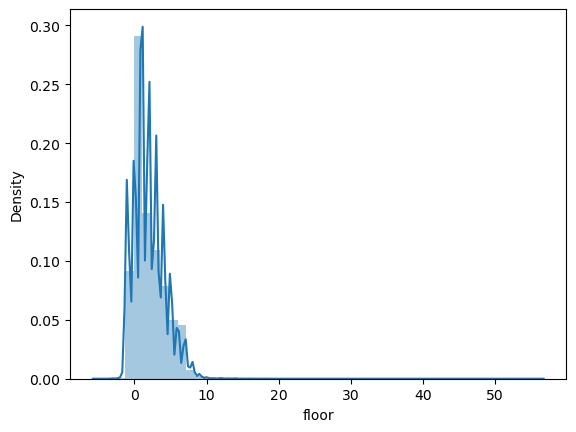

In [153]:
sns.distplot(df_train['floor'])

In [154]:
df_train["floor"].describe() 

count    43242.000000
mean         2.028745
std          2.175129
min         -5.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: floor, dtype: float64

We will input the median (which is also mode and the same as the mean rounded to the nearest integer).

##### Median imputation strategy

In [155]:
# Create an instance of SimpleImputer with median strategy
imputer = SimpleImputer(strategy='median')

# Select the columns to impute
#cols_to_impute = ['energy_efficiency', 'total_floors', 'expenses', 'floor']
cols_to_impute = ['floor']

# Fit the imputer on the selected columns
imputer.fit(df_train[cols_to_impute])

# Impute the missing values in the selected columns
df_train[cols_to_impute] = imputer.transform(df_train[cols_to_impute])


##### Mean imputation strategy

In [156]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(df_train[['construction_year']])
df_train["construction_year"]=imputer.transform(df_train[["construction_year"]])
df_train["age"] = df_train["age"].fillna(2023 - df_train[df_train["age"].isna()]["construction_year"])

#df_train["construction_year"]=df_train["construction_year"].round() # for now we will not round to retain information
# it's estimation anyways

In [157]:
df_train[["construction_year", "age"]]

,construction_year,age
0,1980.000000,43.000000
1,1958.052831,64.947169
2,1960.000000,63.000000
3,1958.052831,64.947169
4,1958.052831,64.947169
...,...,...
46307,1929.000000,94.000000
46308,1920.000000,103.000000
46309,1958.052831,64.947169
46310,1965.000000,58.000000


In [158]:
df_train[df_train["age"].isna()]

,id,price,balcony,conditions,construction_year,latitude,longitude,floor,garden,n_bathrooms,...,proximity_to_center,surface,price_log,city,population_density,city_Milan,city_Rome,city_Venice,city_nan,age


##### Mode imputation strategy

In [159]:
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(df_train[['elevator']])
df_train["elevator"]=imputer.transform(df_train[["elevator"]])

##### Conditions

Only around 2% of observations are missing and it is hard to predict due to unavailability of appropriate data, so we decide to drop these observations. This variable is relatively important (one of the highest correlations with price_log) for explaining the price and we do not want to introduce inaccuracy if we can drop a small portion.

In [160]:
df_train.dropna(subset=['conditions'], inplace=True)

##### Final check for the presence of missing values in the dataframe

In [161]:
if df_train.isna().any().any():
    print("There are missing values in the dataframe")
else:
    print("There are no missing values in the dataframe, the process finished")

There are no missing values in the dataframe, the process finished


So the final number of observations in the dataset after this part of cleaning is 42000.

In [162]:
df_train.shape

(43898, 22)

In [163]:
df_train

,id,price,balcony,conditions,construction_year,latitude,longitude,floor,garden,n_bathrooms,...,proximity_to_center,surface,price_log,city,population_density,city_Milan,city_Rome,city_Venice,city_nan,age
0,10461,60000,1.0,1.0,1980.000000,41.901300,12.700000,2.0,0.0,1.0,...,1.00000,35.0,11.002100,Rome,745.338966,0.0,1.0,0.0,0.0,43.000000
1,51304,900000,0.0,1.0,1958.052831,41.907017,12.481311,3.0,0.0,1.0,...,1.00000,131.0,13.710150,Rome,745.338966,0.0,1.0,0.0,0.0,64.947169
2,33032,33000,0.0,1.0,1960.000000,41.976500,12.440500,4.0,0.0,1.0,...,1.00000,16.0,10.404263,Rome,745.338966,0.0,1.0,0.0,0.0,63.000000
3,62281,166000,0.0,2.0,1958.052831,45.484800,12.198200,1.0,1.0,1.0,...,0.99205,100.0,12.019743,Venice,342.496392,0.0,0.0,1.0,0.0,64.947169
4,45681,410000,1.0,1.0,1958.052831,45.424480,12.328622,3.0,0.0,2.0,...,1.00000,90.0,12.923912,Venice,342.496392,0.0,0.0,1.0,0.0,64.947169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46307,33085,329999,1.0,1.0,1929.000000,41.923500,12.446100,3.0,0.0,1.0,...,1.00000,88.0,12.706845,Rome,745.338966,0.0,1.0,0.0,0.0,94.000000
46308,17403,599000,1.0,0.0,1920.000000,41.916743,12.454925,6.0,0.0,2.0,...,1.00000,189.0,13.303017,Rome,745.338966,0.0,1.0,0.0,0.0,103.000000
46309,33332,549000,1.0,1.0,1958.052831,45.454701,9.242711,2.0,0.0,2.0,...,1.00000,140.0,13.215854,Milan,1928.356787,1.0,0.0,0.0,0.0,64.947169
46310,63367,189000,1.0,1.0,1965.000000,45.445605,9.245942,-1.0,1.0,1.0,...,1.00000,70.0,12.149502,Milan,1928.356787,1.0,0.0,0.0,0.0,58.000000


## Outliers

We have already tackled bivariate outliers by considering ratios between the surface, number of rooms and number of bathrooms exploiting the properties that they are related. For other variables there are no significant relationship, so we will just consider univariate case. We will define outliers in univariate analysis as the data points that are at distance of 1.5 interquartile range from the upper (Q3) or the lower (Q2) quartile.

### Construction year (and age at the same time)

In [164]:
df_train["construction_year"].describe()

count    43898.000000
mean      1958.129576
std         60.593471
min       1000.000000
25%       1958.052831
50%       1960.000000
75%       1972.000000
max       2500.000000
Name: construction_year, dtype: float64

In [165]:
# calculate the interquartile range (IQR) for the construction_year variable
Q1 = df_train['construction_year'].quantile(0.25)
Q3 = df_train['construction_year'].quantile(0.75)
IQR = Q3 - Q1

# calculate the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# identify outliers in the construction_year variable
outliers = df_train[(df_train['construction_year'] < lower_bound) | (df_train['construction_year'] > upper_bound)]

# print the outliers
print(outliers)

          id   price  balcony  conditions  construction_year   latitude  \
9      44039  459000      1.0         2.0             1995.0  41.906400   
10     14881  329000      0.0         2.0             2011.0  41.811100   
12      1432  150000      0.0         1.0             2000.0  41.881900   
18     62735  126118      1.0         3.0             2022.0  41.836673   
19     24569  185000      1.0         3.0             2010.0  41.910800   
...      ...     ...      ...         ...                ...        ...   
46284   8762  195000      0.0         2.0             1920.0  45.491800   
46288  41640  262400      1.0         3.0             2017.0  41.977200   
46304  63389  525000      1.0         2.0             1930.0  45.480000   
46307  33085  329999      1.0         1.0             1929.0  41.923500   
46308  17403  599000      1.0         0.0             1920.0  41.916743   

       longitude  floor  garden  n_bathrooms  ...  proximity_to_center  \
9      12.420300    0.0  

Many of the outliers are either built at the beginning of 20th century or 21st, which is possible so we do not want to delete all these 11547 outliers. However, we want to have a closer look at entries by mistake such as: 2500 and also investigate other anomalies such as the construction year of 1000.

In [166]:
df_train[df_train["construction_year"]>2023]

,id,price,balcony,conditions,construction_year,latitude,longitude,floor,garden,n_bathrooms,...,proximity_to_center,surface,price_log,city,population_density,city_Milan,city_Rome,city_Venice,city_nan,age
72,23446,1550600,1.0,3.0,2024.0,45.450500,9.157100,0.0,1.0,3.0,...,1.0,181.0,14.254153,Milan,1928.356787,1.0,0.0,0.0,0.0,-1.0
549,62627,490000,1.0,3.0,2024.0,45.457200,9.222000,5.0,1.0,1.0,...,1.0,75.0,13.102161,Milan,1928.356787,1.0,0.0,0.0,0.0,-1.0
940,35608,443000,1.0,3.0,2024.0,45.427825,9.202072,1.0,1.0,2.0,...,1.0,160.0,13.001325,Milan,1928.356787,1.0,0.0,0.0,0.0,-1.0
1279,25091,3678000,1.0,3.0,2024.0,45.449600,9.165400,5.0,1.0,3.0,...,1.0,388.0,15.117880,Milan,1928.356787,1.0,0.0,0.0,0.0,-1.0
1669,40169,695000,1.0,3.0,2024.0,41.923500,12.478900,1.0,1.0,2.0,...,1.0,120.0,13.451667,Rome,745.338966,0.0,1.0,0.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45111,39392,319400,1.0,3.0,2024.0,45.512600,9.219800,-1.0,1.0,1.0,...,1.0,60.0,12.674200,Milan,1928.356787,1.0,0.0,0.0,0.0,-1.0
45673,63745,380000,1.0,3.0,2024.0,45.522100,9.152000,6.0,1.0,2.0,...,1.0,111.0,12.847927,Milan,1928.356787,1.0,0.0,0.0,0.0,-1.0
45727,23473,892500,1.0,3.0,2024.0,45.448761,9.159366,-1.0,1.0,2.0,...,1.0,119.0,13.701782,Milan,1928.356787,1.0,0.0,0.0,0.0,-1.0
45973,14181,405000,1.0,3.0,2024.0,41.801300,12.431300,2.0,0.0,2.0,...,1.0,88.0,12.911642,Rome,745.338966,0.0,1.0,0.0,0.0,-1.0


In [167]:
df_train[df_train["construction_year"]<1800]

,id,price,balcony,conditions,construction_year,latitude,longitude,floor,garden,n_bathrooms,...,proximity_to_center,surface,price_log,city,population_density,city_Milan,city_Rome,city_Venice,city_nan,age
151,45951,520000,1.0,1.0,1700.0,45.444700,12.331500,0.0,0.0,1.000000,...,1.0,113.0,13.161584,Venice,342.496392,0.0,0.0,1.0,0.0,323.0
154,58875,530000,1.0,3.0,1600.0,45.434316,12.323534,1.0,0.0,2.000000,...,1.0,109.0,13.180632,Venice,342.496392,0.0,0.0,1.0,0.0,423.0
163,15698,1290000,1.0,2.0,1300.0,41.888000,12.476100,1.0,0.0,3.000000,...,1.0,130.0,14.070153,Rome,745.338966,0.0,1.0,0.0,0.0,723.0
209,8504,698000,1.0,1.0,1700.0,45.446445,12.328056,1.0,0.0,2.000000,...,1.0,130.0,13.455974,Venice,342.496392,0.0,0.0,1.0,0.0,323.0
210,3922,205000,0.0,2.0,1500.0,45.511400,9.252000,2.0,1.0,1.000000,...,1.0,80.0,12.230765,Milan,1928.356787,1.0,0.0,0.0,0.0,523.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45806,1003,490000,1.0,3.0,1500.0,45.434068,12.334472,-1.0,0.0,1.000000,...,1.0,87.0,13.102161,Venice,342.496392,0.0,0.0,1.0,0.0,523.0
45988,6308,285000,1.0,1.0,1500.0,45.436900,12.327200,4.0,0.0,1.000000,...,1.0,50.0,12.560244,Venice,342.496392,0.0,0.0,1.0,0.0,523.0
46042,1383,1679000,1.0,2.0,1700.0,45.435400,12.334600,2.0,1.0,2.775283,...,1.0,370.0,14.333709,Venice,342.496392,0.0,0.0,1.0,0.0,323.0
46115,58824,285000,1.0,2.0,1700.0,45.431100,12.355200,2.0,0.0,1.000000,...,1.0,45.0,12.560244,Venice,342.496392,0.0,0.0,1.0,0.0,323.0


In [168]:
df_train.drop(df_train[(df_train["construction_year"] > 2023) | (df_train["construction_year"] < 1800)].index, inplace=True)

### Latitude and longitude

In [169]:
df_train["latitude"].describe() # seems accurate, Italy's range of latitudes is 35° and 47° N and this data is within this range

count    43124.000000
mean        43.539158
std          1.790524
min         41.690300
25%         41.881100
50%         41.961162
75%         45.466800
max         45.561298
Name: latitude, dtype: float64

In [170]:
df_train["longitude"].describe() # also within the range

count    43124.000000
mean        11.430748
std          1.511878
min          9.060775
25%          9.219164
50%         12.360848
75%         12.488900
max         12.824200
Name: longitude, dtype: float64

### Total_floors

In [171]:
#df_train["total_floors"].describe()

In [172]:
'''
Q1 = df_train['total_floors'].quantile(0.25)
Q3 = df_train['total_floors'].quantile(0.75)
IQR = Q3 - Q1

# calculate the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# identify outliers in the construction_year variable
outliers = df_train[(df_train['total_floors'] < lower_bound) | (df_train['total_floors'] > upper_bound)]

# print the outliers
print(outliers)
'''

"\nQ1 = df_train['total_floors'].quantile(0.25)\nQ3 = df_train['total_floors'].quantile(0.75)\nIQR = Q3 - Q1\n\n# calculate the lower and upper bounds for outliers\nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\n\n# identify outliers in the construction_year variable\noutliers = df_train[(df_train['total_floors'] < lower_bound) | (df_train['total_floors'] > upper_bound)]\n\n# print the outliers\nprint(outliers)\n"

By definition of outliers there are as many as 8561, which is more than half of the data. Here another strategy could be appropriate. We know that the tallest building (with apartments) in Milan has 34 floors, in Rome 22 floors. We will treat 20 floors as the threshold however as these are anomalies.

In [173]:
'''
df_train[df_train["total_floors"]>20]
# there are buildings with more than 100 floors in the dataset and 31960.0 for example, so we need to discard them

df_train.drop(df_train[(df_train["total_floors"] > 20) | (df_train["total_floors"] < 1)].index, inplace=True)
'''

'\ndf_train[df_train["total_floors"]>20]\n# there are buildings with more than 100 floors in the dataset and 31960.0 for example, so we need to discard them\n\ndf_train.drop(df_train[(df_train["total_floors"] > 20) | (df_train["total_floors"] < 1)].index, inplace=True)\n'

### Floors

In [174]:
df_train["floor"].describe()

count    43124.000000
mean         2.035270
std          2.143169
min         -5.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: floor, dtype: float64

In [175]:
df_train[(df_train["floor"]<-1) | (df_train["floor"]>20)] 
df_train.drop(df_train[(df_train["floor"]<-1) | (df_train["floor"]>20)].index, inplace=True)

### N_bathrooms

In [176]:
# df_train["n_bathrooms"].describe()

In [177]:
'''
Q1 = df_train['n_bathrooms'].quantile(0.25)
Q3 = df_train['n_bathrooms'].quantile(0.75)
IQR = Q3 - Q1

# calculate the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# identify outliers in the construction_year variable
outliers = df_train[(df_train['n_bathrooms'] < lower_bound) | (df_train['n_bathrooms'] > upper_bound)]

# print the outliers
print(outliers)
'''

"\nQ1 = df_train['n_bathrooms'].quantile(0.25)\nQ3 = df_train['n_bathrooms'].quantile(0.75)\nIQR = Q3 - Q1\n\n# calculate the lower and upper bounds for outliers\nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\n\n# identify outliers in the construction_year variable\noutliers = df_train[(df_train['n_bathrooms'] < lower_bound) | (df_train['n_bathrooms'] > upper_bound)]\n\n# print the outliers\nprint(outliers)\n"

In [178]:
# df_train.drop(df_train[(df_train["n_bathrooms"] < lower_bound) | (df_train["n_bathrooms"] > upper_bound)].index, inplace=True)

### Surface

In [179]:
# df_train["surface"].describe()

In [180]:
# 370 is likely for a big aparment/ house, but 0 not, we will discard surface areas below 15
# df_train[df_train["surface"]<15]

In [181]:
# df_train.drop(df_train[(df_train["surface"] < 15)].index, inplace=True)

### Number of rooms

In [182]:
# df_train["n_rooms"].describe() 

Plausible, we do not modify.

### Expenses

In [183]:
# df_train["expenses"].describe() 

In [184]:
'''
# Large standard deviation and range.
Q1 = df_train['expenses'].quantile(0.25)
Q3 = df_train['expenses'].quantile(0.75)
IQR = Q3 - Q1

# calculate the lower and upper bounds for outliers
# to this data, with a lot of extreme values, we decide to increase the threshold so that we reject fewer observations
# however, setting this threshold to even 3 IQR from Q1 and Q3 (Turkey's method) still would lead us to reject a significant proportion of data
# we set this threshold to 5
lower_bound = Q1 - 5 * IQR
upper_bound = Q3 + 5 * IQR

# identify outliers in the construction_year variable
outliers = df_train[(df_train['expenses'] < lower_bound) | (df_train['expenses'] > upper_bound)]

# print the outliers
print(outliers)
'''

"\n# Large standard deviation and range.\nQ1 = df_train['expenses'].quantile(0.25)\nQ3 = df_train['expenses'].quantile(0.75)\nIQR = Q3 - Q1\n\n# calculate the lower and upper bounds for outliers\n# to this data, with a lot of extreme values, we decide to increase the threshold so that we reject fewer observations\n# however, setting this threshold to even 3 IQR from Q1 and Q3 (Turkey's method) still would lead us to reject a significant proportion of data\n# we set this threshold to 5\nlower_bound = Q1 - 5 * IQR\nupper_bound = Q3 + 5 * IQR\n\n# identify outliers in the construction_year variable\noutliers = df_train[(df_train['expenses'] < lower_bound) | (df_train['expenses'] > upper_bound)]\n\n# print the outliers\nprint(outliers)\n"

In [185]:
# df_train.drop(df_train[(df_train["expenses"] < lower_bound) | (df_train["expenses"] > upper_bound)].index, inplace=True)

### Energy efficiency

In [186]:
# df_train["energy_efficiency"].describe() 

Very big standard deviation and very small minimum and maximum value. We are going to look into it.

In [187]:
'''
Q1 = df_train['energy_efficiency'].quantile(0.25)
Q3 = df_train['energy_efficiency'].quantile(0.75)
IQR = Q3 - Q1

# calculate the lower and upper bounds for outliers
lower_bound = Q1 - 5 * IQR
upper_bound = Q3 + 5 * IQR

# identify outliers in the construction_year variable
outliers = df_train[(df_train['energy_efficiency'] < lower_bound) | (df_train['energy_efficiency'] > upper_bound)]

# print the outliers
print(outliers)
'''

"\nQ1 = df_train['energy_efficiency'].quantile(0.25)\nQ3 = df_train['energy_efficiency'].quantile(0.75)\nIQR = Q3 - Q1\n\n# calculate the lower and upper bounds for outliers\nlower_bound = Q1 - 5 * IQR\nupper_bound = Q3 + 5 * IQR\n\n# identify outliers in the construction_year variable\noutliers = df_train[(df_train['energy_efficiency'] < lower_bound) | (df_train['energy_efficiency'] > upper_bound)]\n\n# print the outliers\nprint(outliers)\n"

Even updated threshold (5IQR from Q1 and Q3) instead of 1.5IQR would force us to reject too many observations. Therefore, here we will use another approach, called Winsorizing method. We will replace extreme values with a less extreme value, values above the 99th percentile with the value at the 99th percentile, and values below the 1st percentile with the value at the 1st percentile.

In [188]:
# df_train[df_train["energy_efficiency"]>df_train["energy_efficiency"].quantile(0.99)]["energy_efficiency"]=df_train["energy_efficiency"].quantile(0.99)

In [189]:
# df_train[df_train["energy_efficiency"]<df_train["energy_efficiency"].quantile(0.01)]["energy_efficiency"]=df_train["energy_efficiency"].quantile(0.01)

### Proximity to center

In [190]:
df_train["proximity_to_center"].describe() # looks likely, no significant outliers

count    43086.000000
mean         0.994762
std          0.029777
min          0.588014
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: proximity_to_center, dtype: float64

### Binary variables: garden, balcony and elevator

In [191]:
df_train["balcony"].value_counts()

1.0    29187
0.0    13899
Name: balcony, dtype: int64

In [192]:
df_train["garden"].value_counts()

0.0    29087
1.0    13999
Name: garden, dtype: int64

In [193]:
df_train["elevator"].value_counts()

1.0    41737
0.0     1349
Name: elevator, dtype: int64

### Conditions

In [194]:
df_train["conditions"].value_counts()

1.0    20764
2.0    10176
3.0     6714
0.0     5432
Name: conditions, dtype: int64

### N_bathrooms, n_rooms, surface

We took care of these outliers already, which was better because we could derive a model with relative high amount of data, while also discarding outliers.

### City

In [195]:
df_train["city"].value_counts()

Rome      23167
Milan     13378
Venice     6541
Name: city, dtype: int64

#Treviso has only 4 entries and big cities have way more. Let's look at the distance from the center of Treviso to determine whether it should be considered as Venice.

In [196]:
#df_train[df_train["city"]=="Treviso"][["city", "proximity_to_center"]]

Indeed, the proximity to the center is small so it provides evidence that small cities in the proximity of a big major city can be counted as the corresponding major city. That is why, we will now modify columns "population_density" and "city" to account for this observation. We will also filter the dataset with cities, population densities and population sizes according to the value of the population size/ density to include only cities above certain threshold as the dataset has such an approach to the classification of cities. Then we will compute the distances to assign appropriate city names based on longitudes and latitudes.

In [197]:
### TAKE CARE OF SPECIFIC CITIES 

### Price_log

In [198]:
df_train["price_log"].describe()

count    43086.000000
mean        12.691127
std          0.749033
min          5.036953
25%         12.201060
50%         12.641097
75%         13.112313
max         17.385043
Name: price_log, dtype: float64

In [199]:
# calculate the interquartile range (IQR) 
Q1 = df_train['price_log'].quantile(0.25)
Q3 = df_train['price_log'].quantile(0.75)
IQR = Q3 - Q1

# calculate the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# identify outliers in the construction_year variable
outliers = df_train[(df_train['price_log'] < lower_bound) | (df_train['price_log']> upper_bound)]

# print the outliers
print(outliers)

          id    price  balcony  conditions  construction_year   latitude  \
2      33032    33000      0.0         1.0        1960.000000  41.976500   
31     46831  1950000      1.0         2.0        1890.000000  45.464800   
39     11827    49000      0.0         0.0        1958.052831  45.485071   
47      4317  2050000      1.0         1.0        1955.000000  45.478767   
71      1169  3250000      1.0         1.0        1958.052831  45.474968   
...      ...      ...      ...         ...                ...        ...   
46036  26256  2990000      1.0         2.0        1920.000000  41.919900   
46108   9575  3500000      1.0         3.0        1800.000000  45.440343   
46205  58602  1990000      1.0         2.0        1900.000000  41.906700   
46226  60455  2790000      1.0         2.0        1953.000000  45.479900   
46306  63289  2260000      1.0         1.0        1950.000000  45.470800   

       longitude  floor  garden  n_bathrooms  ...  proximity_to_center  \
2      12.440

In [200]:
print(lower_bound, upper_bound)
print(df_train["price_log"].quantile(0.01), df_train["price_log"].quantile(0.99))
# similar

10.834180696940333 14.479192448317125
11.082142548877775 14.77102200299171


In [201]:
df_train["price"].describe()

count    4.308600e+04
mean     4.551312e+05
std      7.037257e+05
min      1.540000e+02
25%      1.990000e+05
50%      3.090000e+05
75%      4.950000e+05
max      3.550000e+07
Name: price, dtype: float64

In [202]:
print(df_train["price"].quantile(0.01), df_train["price"].quantile(0.99))
# we want to keep prices close to this range which seems reasonable and corresponds to quantiles 
# we do not want to include houses beyond these values, especially maximum and minimum in the description seem unrealistic

65000.0 2600000.0


In [203]:
# df_train.drop(df_train[(df_train["price_log"] < lower_bound) | (df_train["price_log"] > upper_bound)].index, inplace=True)

In [204]:
df_train=df_train.reset_index(drop=True)
df_train

,id,price,balcony,conditions,construction_year,latitude,longitude,floor,garden,n_bathrooms,...,proximity_to_center,surface,price_log,city,population_density,city_Milan,city_Rome,city_Venice,city_nan,age
0,10461,60000,1.0,1.0,1980.000000,41.901300,12.700000,2.0,0.0,1.0,...,1.00000,35.0,11.002100,Rome,745.338966,0.0,1.0,0.0,0.0,43.000000
1,51304,900000,0.0,1.0,1958.052831,41.907017,12.481311,3.0,0.0,1.0,...,1.00000,131.0,13.710150,Rome,745.338966,0.0,1.0,0.0,0.0,64.947169
2,33032,33000,0.0,1.0,1960.000000,41.976500,12.440500,4.0,0.0,1.0,...,1.00000,16.0,10.404263,Rome,745.338966,0.0,1.0,0.0,0.0,63.000000
3,62281,166000,0.0,2.0,1958.052831,45.484800,12.198200,1.0,1.0,1.0,...,0.99205,100.0,12.019743,Venice,342.496392,0.0,0.0,1.0,0.0,64.947169
4,45681,410000,1.0,1.0,1958.052831,45.424480,12.328622,3.0,0.0,2.0,...,1.00000,90.0,12.923912,Venice,342.496392,0.0,0.0,1.0,0.0,64.947169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43081,33085,329999,1.0,1.0,1929.000000,41.923500,12.446100,3.0,0.0,1.0,...,1.00000,88.0,12.706845,Rome,745.338966,0.0,1.0,0.0,0.0,94.000000
43082,17403,599000,1.0,0.0,1920.000000,41.916743,12.454925,6.0,0.0,2.0,...,1.00000,189.0,13.303017,Rome,745.338966,0.0,1.0,0.0,0.0,103.000000
43083,33332,549000,1.0,1.0,1958.052831,45.454701,9.242711,2.0,0.0,2.0,...,1.00000,140.0,13.215854,Milan,1928.356787,1.0,0.0,0.0,0.0,64.947169
43084,63367,189000,1.0,1.0,1965.000000,45.445605,9.245942,-1.0,1.0,1.0,...,1.00000,70.0,12.149502,Milan,1928.356787,1.0,0.0,0.0,0.0,58.000000


## Model

In [205]:
df_train.columns

Index(['id', 'price', 'balcony', 'conditions', 'construction_year', 'latitude',
       'longitude', 'floor', 'garden', 'n_bathrooms', 'elevator', 'n_rooms',
       'proximity_to_center', 'surface', 'price_log', 'city',
       'population_density', 'city_Milan', 'city_Rome', 'city_Venice',
       'city_nan', 'age'],
      dtype='object')

We take the target variable to be transformed price, price_log, then we will go back to the original value applying the inverse transformation.

In [300]:
scalerX=StandardScaler()
scalerY=StandardScaler()
'''
X=df_train[['balcony', 'conditions', 'energy_efficiency', 'expenses', 'floor', 'garden',
       'n_bathrooms', 'elevator', 'total_floors', 'n_rooms',
       'proximity_to_center', 'surface',
       'population_density', 'age']]
'''
y=df_train["price_log"]
X=df_train[['balcony', 'conditions', 'floor', 'garden',
       'n_bathrooms', 'elevator', 'n_rooms',
       'proximity_to_center', 'surface', 'age', 'city_Milan', 'city_Rome', 'city_Venice']]
X_scaled=scalerX.fit_transform(X)
y_scaled=scalerY.fit_transform(y[:,np.newaxis]) # y_scaled is log by default!!

#### CHANGE X 


In [301]:
y.shape

(43086,)

In [302]:
'''
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=9)

# Train a random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=9)
rf.fit(X_train, y_train)

# Evaluate the model on the test set
score = rf.score(X_test, y_test)
print(f"R^2 score: {score:.2f}")

##########
model_pred=rf.predict(X_test)
model_pred_rescaled_log=scalerY.inverse_transform(model_pred[:,np.newaxis])
model_pred=np.exp(model_pred_rescaled_log)
price_test=np.exp(scalerY.inverse_transform(y_test))
# print("R^2 after rescaling to the original scale", r2_score(price_test, model_pred))
# do k-fold??
'''

'\n# Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=9)\n\n# Train a random forest model\nrf = RandomForestRegressor(n_estimators=100, random_state=9)\nrf.fit(X_train, y_train)\n\n# Evaluate the model on the test set\nscore = rf.score(X_test, y_test)\nprint(f"R^2 score: {score:.2f}")\n\n##########\nmodel_pred=rf.predict(X_test)\nmodel_pred_rescaled_log=scalerY.inverse_transform(model_pred[:,np.newaxis])\nmodel_pred=np.exp(model_pred_rescaled_log)\nprice_test=np.exp(scalerY.inverse_transform(y_test))\n# print("R^2 after rescaling to the original scale", r2_score(price_test, model_pred))\n# do k-fold??\n'

### Random forest

In [303]:
# Hyperparameter tuning

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=9)


# Define the parameter grid to search over
param_grid = {
    'n_estimators': [600, 700, 800],
    'max_depth': [5, 20, 30],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [1, 3, 5],
}

# Create a random forest regressor object
rf = RandomForestRegressor(random_state=9)

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)

Best parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 800}
Best score:  0.3159024406733178


In [210]:
df_train.columns

Index(['id', 'price', 'balcony', 'conditions', 'construction_year', 'latitude',
       'longitude', 'floor', 'garden', 'n_bathrooms', 'elevator', 'n_rooms',
       'proximity_to_center', 'surface', 'price_log', 'city',
       'population_density', 'city_Milan', 'city_Rome', 'city_Venice',
       'city_nan', 'age'],
      dtype='object')

In [304]:
# Train a random forest model
rf_prices = RandomForestRegressor(n_estimators=800, max_depth=20, min_samples_leaf=1, min_samples_split=10, random_state=9)

# Perform k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=9)

scores = []
for train_index, val_index in kf.split(X_train):
    # Split the training data into training and validation sets
    X_train_fold, X_val = X_train[train_index], X_train[val_index]
    y_train_fold, y_val = y_train[train_index], y_train[val_index]

    # Train the model on the training set
    rf_prices.fit(X_train_fold, y_train_fold)

    # Evaluate the model on the validation set
    val_pred = rf_prices.predict(X_val)

    # Compute the R^2 score on the validation set
    score = r2_score(y_val, val_pred)
    scores.append(score)

# Compute the average R^2 score over all folds
avg_score = sum(scores) / len(scores)
print(f"Average R^2 score: {avg_score:.2f}")

Average R^2 score: 0.68


In [305]:
# Train the model on the entire training set
rf_prices.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = rf_prices.predict(X_test)
test_pred_rescaled_log = scalerY.inverse_transform(y_pred[:,np.newaxis])
test_pred = np.exp(test_pred_rescaled_log)
price_test = np.exp(scalerY.inverse_transform(y_test))
score = r2_score(price_test, test_pred)
print(f"R^2 score on the test set: {score:.2f}")

# Compute the mean squared error on the test set
mse = mean_squared_error(price_test, test_pred)
mse=mean_squared_error(y_test, y_pred)
print(f"Mean squared error on the test set: {mse:.2f}")

R^2 score on the test set: 0.54
Mean squared error on the test set: 0.29


### SVM

In [213]:
### SVM

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf']
}

# Create a support vector machine regressor object
svr = SVR()

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)

# Train an SVM model with the best parameters
best_svr = SVR(**grid_search.best_params_)
best_svr.fit(X_train, y_train)

# Evaluate the model on the test set
score = best_svr.score(X_test, y_test)
print(f"R^2 score: {score:.2f}")

# Compute the mean squared error on the test set
from sklearn.metrics import mean_squared_error
y_pred = best_svr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse:.2f}")

Best parameters:  {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}
Best score:  0.34628166966659474
R^2 score: 0.67
Mean squared error: 0.32


In [214]:
#!pip install torch torchvision

In [215]:
#!pip install tensorflow

In [216]:
#!pip install --upgrade numpy

In [217]:
#!pip uninstall tensorflow

In [218]:
#!pip install --upgrade pip
#!pip install tensorflow

In [219]:
'''
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=9)

# Define the model architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mse', optimizer='adam')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)

# Make predictions on new data
predictions_scaled = model.predict(X_new)

# Invert the scaling of the predictions
predictions = scalerY.inverse_transform(predictions_scaled)
'''

"\nimport tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense, Dropout\nfrom sklearn.model_selection import train_test_split\n\n# Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=9)\n\n# Define the model architecture\nmodel = Sequential()\nmodel.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(32, activation='relu'))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(1, activation='linear'))\n\n# Compile the model\nmodel.compile(loss='mse', optimizer='adam')\n\n# Train the model\nhistory = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))\n\n# Evaluate the model on the test set\nloss = model.evaluate(X_test, y_test)\n\n# Make predictions on new data\npredictions_scaled = model.predict(X_new)\n\n# Invert the scaling of the predictions\npredictions = sca

In [220]:
'''
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Convert Pandas DataFrame to NumPy arrays
X_np = X.values.astype(np.float32)
y_np = y.values.astype(np.float32)


class MyModel(nn.Module):
    def __init__(self, input_size):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

dataset = MyDataset(X_np, y_np)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)


# Instantiate the model, loss function, and optimizer
model = MyModel(input_size=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Train the model
for epoch in range(100):
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss={loss.item()}")

# Make predictions on new data
X_new = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 0], [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]], dtype=torch.float32)
y_pred = model(X_new)
print(f"Predictions: {y_pred.argmax(dim=1)}")
'''

'\nimport torch\nimport torch.nn as nn\nimport torch.optim as optim\nfrom torch.utils.data import Dataset, DataLoader\n\n# Convert Pandas DataFrame to NumPy arrays\nX_np = X.values.astype(np.float32)\ny_np = y.values.astype(np.float32)\n\n\nclass MyModel(nn.Module):\n    def __init__(self, input_size):\n        super(MyModel, self).__init__()\n        self.fc1 = nn.Linear(input_size, 64)\n        self.fc2 = nn.Linear(64, 32)\n        self.fc3 = nn.Linear(32, 2)\n        \n    def forward(self, x):\n        x = torch.relu(self.fc1(x))\n        x = torch.relu(self.fc2(x))\n        x = self.fc3(x)\n        return x\n\ndataset = MyDataset(X_np, y_np)\ndataloader = DataLoader(dataset, batch_size=2, shuffle=True)\n\n\n# Instantiate the model, loss function, and optimizer\nmodel = MyModel(input_size=10)\ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.SGD(model.parameters(), lr=0.001)\n\n# Train the model\nfor epoch in range(100):\n    for X_batch, y_batch in dataloader:\n        optimiz

In [221]:
'''
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

class HousePricesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(14, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x.squeeze()

dataset = HousePricesDataset(X=df_train[['balcony', 'conditions', 'energy_efficiency', 'expenses', 'floor', 'garden', 'n_bathrooms', 'elevator', 'total_floors', 'n_rooms', 'proximity_to_center', 'surface', 'population_density', 'age']], 
                             y=df_train["price_log"])

dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(10):
    running_loss = 0.0
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, loss: {running_loss/len(dataloader)}")
'''

'\nimport torch\nfrom torch.utils.data import Dataset, DataLoader\nfrom torch import nn, optim\n\nclass HousePricesDataset(Dataset):\n    def __init__(self, X, y):\n        self.X = torch.tensor(X.values, dtype=torch.float32)\n        self.y = torch.tensor(y.values, dtype=torch.float32)\n        \n    def __len__(self):\n        return len(self.X)\n    \n    def __getitem__(self, idx):\n        return self.X[idx], self.y[idx]\n    \nclass Net(nn.Module):\n    def __init__(self):\n        super(Net, self).__init__()\n        self.fc1 = nn.Linear(14, 64)\n        self.fc2 = nn.Linear(64, 32)\n        self.fc3 = nn.Linear(32, 1)\n        \n    def forward(self, x):\n        x = torch.relu(self.fc1(x))\n        x = torch.relu(self.fc2(x))\n        x = self.fc3(x)\n        return x.squeeze()\n\ndataset = HousePricesDataset(X=df_train[[\'balcony\', \'conditions\', \'energy_efficiency\', \'expenses\', \'floor\', \'garden\', \'n_bathrooms\', \'elevator\', \'total_floors\', \'n_rooms\', \'proxi

In [222]:
'''
# set model to evaluation mode
model.eval()

# initialize lists to store predictions and actual values
y_pred = []
y_true = []

# disable gradient computation
with torch.no_grad():
    for X_batch, y_batch in dataloader:
        # make predictions
        pred_batch = model(X_batch)
        
        # append predictions and actual values to lists
        y_pred.extend(pred_batch.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

# calculate R^2 score
r2 = r2_score(y_true, y_pred)

print(f"R^2 score: {r2:.4f}")
'''

'\n# set model to evaluation mode\nmodel.eval()\n\n# initialize lists to store predictions and actual values\ny_pred = []\ny_true = []\n\n# disable gradient computation\nwith torch.no_grad():\n    for X_batch, y_batch in dataloader:\n        # make predictions\n        pred_batch = model(X_batch)\n        \n        # append predictions and actual values to lists\n        y_pred.extend(pred_batch.cpu().numpy())\n        y_true.extend(y_batch.cpu().numpy())\n\n# calculate R^2 score\nr2 = r2_score(y_true, y_pred)\n\nprint(f"R^2 score: {r2:.4f}")\n'

In [223]:
import torch
import torch.nn as nn
import numpy as np

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(13, 64)   # Input layer -> Hidden layer 1
        self.fc2 = nn.Linear(64, 32)   # Hidden layer 1 -> Hidden layer 2
        self.fc3 = nn.Linear(32, 1)    # Hidden layer 2 -> Output layer
        self.relu = nn.ReLU()          # Activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the training loop
def train(model, X, y, optimizer, criterion, epochs):
    for epoch in range(epochs):
        # Set the model to training mode
        model.train()
        
        # Forward pass
        y_pred = model(X)
        loss = criterion(y_pred, y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print the loss every 100 epochs
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        # Predict the target variable using the test data
        y_pred = model(X)
        # Calculate the mean squared error of the predictions
        mse = criterion(y_pred, y).item()
        print(f'\nMean Squared Error: {mse:.4f}')

# Convert data to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# Create the neural network
model = Net()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
train(model, X_tensor, y_tensor, optimizer, criterion, epochs=1000)

Epoch [100/1000], Loss: 0.3877
Epoch [200/1000], Loss: 0.3485
Epoch [300/1000], Loss: 0.3370
Epoch [400/1000], Loss: 0.3310
Epoch [500/1000], Loss: 0.3261
Epoch [600/1000], Loss: 0.3217
Epoch [700/1000], Loss: 0.3178
Epoch [800/1000], Loss: 0.3149
Epoch [900/1000], Loss: 0.3126
Epoch [1000/1000], Loss: 0.3106

Mean Squared Error: 0.3106


In [224]:
X_scaled.shape

(43086, 13)

### Gradient boosting

In [225]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
}

# create a GradientBoostingRegressor object
gb = GradientBoostingRegressor(random_state=9)

# perform grid search with cross-validation
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_scaled, y_scaled)

# print the best parameters and the corresponding mean squared error
print("Best parameters:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)


Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best score: 0.30224444435475706


In [226]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=9)

# create a GradientBoostingRegressor object with the best hyperparameters
gb = GradientBoostingRegressor(n_estimators=200, max_depth=7, learning_rate=0.1, random_state=9)

# train the model on the training data
gb.fit(X_train, y_train)

# predict on the test data and compute the mean squared error
y_pred = gb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error:", mse)

# Evaluate the model on the test set

test_pred_rescaled_log = scalerY.inverse_transform(y_pred[:,np.newaxis])
test_pred = np.exp(test_pred_rescaled_log)
price_test = np.exp(scalerY.inverse_transform(y_test))
score = r2_score(price_test, test_pred)
print(f"R^2 score on the test set: {score:.2f}")

# Compute the mean squared error on the test set
mse = mean_squared_error(price_test, test_pred)
print(f"Mean squared error on the test set: {mse:.2f}")



Mean squared error: 0.28526442118531664
R^2 score on the test set: 0.55
Mean squared error on the test set: 160253283418.31


In [227]:
from sklearn.linear_model import ElasticNetCV
from sklearn.datasets import make_regression

# generate some random data
X, y = make_regression(n_samples=100, n_features=10, random_state=9)

# create an instance of ElasticNetCV
enet_cv = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], 
                       alphas=np.logspace(-5, 2, 100), 
                       cv=5, 
                       random_state=9)

# fit the model on the data
enet_cv.fit(X, y)

# print the best alpha and l1_ratio parameters
print(f"Best alpha: {enet_cv.alpha_}")
print(f"Best l1_ratio: {enet_cv.l1_ratio_}")

Best alpha: 1e-05
Best l1_ratio: 1.0


In [228]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Assuming X is your feature matrix and y is your target variable
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=9)

# Set up the Elastic Net model with the optimized hyperparameters
elastic_net = ElasticNet(alpha=1e-05, l1_ratio=1.0, max_iter=10000)

# Fit the model to the training data
elastic_net.fit(X_train, y_train)

# Predict on the test set
y_pred = elastic_net.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  0.42662662552551434


In [229]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=9)

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Create the parameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create a Ridge regression object
ridge = Ridge()

# Create the GridSearchCV object with MSE as the scoring metric
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Use the best hyperparameters to fit the model to the training data
best_ridge = Ridge(alpha=grid_search.best_params_['alpha'])
best_ridge.fit(X_train, y_train)

# Predict the target variable using the test data
y_pred = best_ridge.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: ", mse)

Best hyperparameters:  {'alpha': 10}
Mean squared error:  0.42662518000543426


In [230]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=9)

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Create the parameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create a Lasso regression object
lasso = Lasso()

# Create the GridSearchCV object with MSE as the scoring metric
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Use the best hyperparameters to fit the model to the training data
best_lasso = Lasso(alpha=grid_search.best_params_['alpha'])
best_lasso.fit(X_train, y_train)

# Predict the target variable using the test data
y_pred = best_lasso.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: ", mse)

Best hyperparameters:  {'alpha': 0.001}
Mean squared error:  0.4266345811491474


## Test data

In [442]:
df_test = pd.read_csv('./test_updated.csv')

In [443]:
df_test.drop(columns=["energy_efficiency", "expenses", "total_floors"], axis=1, inplace=True)

### Encoding categorical variables

In [444]:
# conditions

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

# a list of categories in the desired order
category_order = ['Unknown', 'Da ristrutturare', 'Buono stato / Abitabile', 'Ottimo / Ristrutturato', 'Nuovo / Nuova costruzione']

# fill NaN values with a string 'Unknown' in order to be able to use the OrdinalEncoder
df_test['conditions'] = df_test['conditions'].fillna('Unknown')

# create an instance of the OrdinalEncoder and fit on the category order
ordinal_encoder = OrdinalEncoder(categories=[category_order])

# encode the categories in the specified order
conditions_encoded = ordinal_encoder.fit_transform(df_test[["conditions"]])

# we want the categories to take values between 0 and 3 and 'Unknown' to take the value of -1 (later we will replace it with
# one of the categories while taking care of missing values)
# create an instance of the MinMaxScaler and fit on the encoded values
scaler = MinMaxScaler(feature_range=(-1, 3))
conditions_scaled = scaler.fit_transform(conditions_encoded)

print(conditions_scaled[:10])

df_test["conditions"]=conditions_scaled
print(df_test["conditions"]) # type float64
df_test["conditions"].replace(-1, np.nan, inplace=True)

[[3.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [0.]
 [3.]
 [1.]
 [1.]]
0        3.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
19783    1.0
19784    1.0
19785    1.0
19786    2.0
19787    1.0
Name: conditions, Length: 19788, dtype: float64


In [445]:
df_test["balcony"].value_counts()

True    13056
Name: balcony, dtype: int64

In [446]:
# balcony
df_test["balcony"][df_test["balcony"]==True]=1
df_test["balcony"][df_test["balcony"].isna()]=-1 # needed to convert dtype of "balcony" to float
df_test["balcony"].astype(int)
df_test["balcony"].replace(-1, np.nan, inplace=True)
df_test["balcony"]

0        1.0
1        NaN
2        NaN
3        1.0
4        1.0
        ... 
19783    1.0
19784    NaN
19785    NaN
19786    1.0
19787    1.0
Name: balcony, Length: 19788, dtype: float64

In [447]:
df_test["garden"].value_counts()

True    6345
Name: garden, dtype: int64

In [448]:
# garden
df_test["garden"][df_test["garden"]==True]=1
df_test["garden"][df_test["garden"].isna()]=-1 # needed to convert dtype of "balcony" to float
df_test["garden"].astype(int)
df_test["garden"].replace(-1, np.nan, inplace=True)
df_test["garden"]

0        1.0
1        1.0
2        NaN
3        NaN
4        NaN
        ... 
19783    NaN
19784    NaN
19785    NaN
19786    NaN
19787    NaN
Name: garden, Length: 19788, dtype: float64

### Adding explanatory variables

In [449]:
# city and population density

# Create a list to store the city names and pop_densities
city_names = []
pop_densities=[]

# Iterate over the rows in the df_test dataframe
for index, row in df_test.iterrows():
    # Get the coordinates of the current city
    lat2, lon2 = row['latitude'], row['longitude']
    if np.isnan(lat2) or np.isnan(lon2):
        city_names.append(np.nan)
        pop_densities.append(np.nan)
    else:
        # Calculate the distances to all cities in the cities_df dataframe
        distances = [(distance(lat1, lon1, lat2, lon2), name) for lat1, lon1, name in zip(df_lat_lng_pop['lat'], df_lat_lng_pop['lng'], df_lat_lng_pop['city'])]
    
        # Find the city with the shortest distance
        closest_city = min(distances)
        pop_density = df_lat_lng_pop.loc[df_lat_lng_pop["city"] == closest_city[1], "population_density"].values[0]
    
        # Add the name of the closest city to the city_names list
        city_names.append(closest_city[1])
        pop_densities.append(pop_density)
        
        
        
df_test["city"]=city_names
df_test["population_density"]=pop_densities

In [450]:
# age
df_test["age"] = np.nan  # create a new column "age" and initialize with NaNs
mask = ~df_test["construction_year"].isna()  # create a boolean mask for non-missing values of construction_year
df_test.loc[mask, "age"] = 2023 - df_test.loc[mask, "construction_year"]  # calculate age for non-missing values

#### Outliers

In [451]:
df_test["age"].describe() # in the test set we have negative age of the house

count    13824.000000
mean        65.190611
std         73.735918
min        -43.000000
25%         34.000000
50%         56.000000
75%         73.000000
max       1018.000000
Name: age, dtype: float64

For the test set, we cannot just remove unreliable observations, but we may replace the incorrect or possibly incorrect values for the age with the closest value within the range assumed to be true during the training, i.e. 2023, 1800, respectively.

In [452]:
df_test[(df_test["construction_year"]>2023) | (df_test["construction_year"]<1800)]

,id,balcony,conditions,construction_year,latitude,longitude,floor,garden,n_bathrooms,elevator,n_rooms,proximity_to_center,surface,city,population_density,age
118,12761,NaN,2.0,1100.0,45.414900,9.241500,0.0,NaN,2.0,1.0,2.0,1.0,70.0,Milan,1928.356787,923.0
153,5818,1.0,1.0,1600.0,45.440400,12.328100,3.0,NaN,1.0,NaN,4.0,1.0,100.0,Venice,342.496392,423.0
260,9447,NaN,1.0,1700.0,45.436874,12.341147,-1.0,NaN,3.0,NaN,7.0,1.0,230.0,Venice,342.496392,323.0
348,35222,NaN,1.0,1700.0,41.832591,12.539441,NaN,NaN,5.0,NaN,4.0,1.0,445.0,Rome,745.338966,323.0
377,44941,NaN,1.0,1400.0,45.434000,12.339600,3.0,NaN,2.0,NaN,5.0,1.0,141.0,Venice,342.496392,623.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19561,23214,1.0,1.0,1700.0,41.906200,12.479800,2.0,NaN,2.0,NaN,5.0,1.0,164.0,Rome,745.338966,323.0
19564,52176,1.0,1.0,1700.0,41.905521,12.479510,0.0,NaN,NaN,NaN,5.0,1.0,484.0,Rome,745.338966,323.0
19590,37928,1.0,1.0,1600.0,45.434300,12.331900,1.0,NaN,3.0,NaN,3.0,1.0,119.0,Venice,342.496392,423.0
19605,54962,1.0,0.0,1600.0,41.893106,12.479662,-1.0,NaN,4.0,1.0,8.0,1.0,300.0,Rome,745.338966,423.0


In [453]:
df_test.loc[df_test["construction_year"] > 2023, "construction_year"] = 2023
df_test.loc[df_test["construction_year"] < 1800, "construction_year"] = 1800
df_test.loc[df_test["age"]<0, "age"]=0
df_test.loc[df_test["age"]>223, "age"]=223


In [454]:
df_test["floor"].describe()

count    18912.000000
mean         2.003278
std          2.162479
min         -5.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         21.000000
Name: floor, dtype: float64

In [455]:
df_test.loc[df_test["floor"] < -1, "floor"] = -1
df_test.loc[df_test["floor"] > 20, "floor"] = 20

Outliers for surface, n_rooms, n_bathrooms

In [456]:
df_test["surface"].describe()

count    19625.000000
mean       115.136662
std         89.581847
min          0.000000
25%         66.000000
50%         90.000000
75%        130.000000
max        990.000000
Name: surface, dtype: float64

Minimum surface is 0, we replace values below 15 with 15.

In [457]:
df_test[df_test["surface"]<15]

,id,balcony,conditions,construction_year,latitude,longitude,floor,garden,n_bathrooms,elevator,n_rooms,proximity_to_center,surface,city,population_density,age
2787,55506,NaN,3.0,NaN,41.906118,12.489542,NaN,NaN,NaN,NaN,NaN,1.000000,0.0,Rome,745.338966,NaN
3048,28320,1.0,1.0,NaN,41.972760,12.426491,2.0,NaN,5.0,NaN,9.0,1.000000,0.0,Rome,745.338966,NaN
3584,42996,NaN,3.0,NaN,45.511500,9.225540,NaN,NaN,NaN,NaN,5.0,1.000000,0.0,Milan,1928.356787,NaN
3646,53539,NaN,0.0,NaN,45.462100,9.186770,NaN,NaN,NaN,NaN,5.0,1.000000,0.0,Milan,1928.356787,NaN
3882,21914,NaN,NaN,NaN,45.445900,12.317300,4.0,NaN,NaN,NaN,NaN,1.000000,0.0,Venice,342.496392,NaN
3959,3580,1.0,1.0,NaN,42.028955,12.374326,3.0,1.0,8.0,NaN,2.0,1.000000,10.0,Rome,745.338966,NaN
4370,36045,NaN,NaN,2000.0,45.521400,9.134400,1.0,NaN,NaN,NaN,1.0,1.000000,11.0,Milan,1928.356787,23.0
4589,27924,1.0,1.0,1960.0,41.911171,12.476380,0.0,NaN,NaN,NaN,5.0,1.000000,0.0,Rome,745.338966,63.0
4648,44179,NaN,1.0,NaN,45.494202,9.229700,5.0,NaN,NaN,NaN,5.0,1.000000,0.0,Milan,1928.356787,NaN
4955,2996,1.0,2.0,1800.0,41.902527,12.484413,1.0,NaN,NaN,NaN,5.0,1.000000,0.0,Rome,745.338966,223.0


In [458]:
df_test.loc[df_test["surface"] < 15, "surface"] = 15

In [459]:
df_test["n_rooms"].describe()

count    19647.000000
mean         3.276785
std          1.328603
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          9.000000
Name: n_rooms, dtype: float64

In [460]:
df_test["n_bathrooms"].describe()

count    18837.000000
mean         1.550512
std          0.758864
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          9.000000
Name: n_bathrooms, dtype: float64

In [461]:
df_test["n_bathrooms"].value_counts()

1.0    10723
2.0     6343
3.0     1488
4.0      171
5.0       63
6.0       24
7.0       12
8.0       10
9.0        3
Name: n_bathrooms, dtype: int64

In [462]:
df_test["n_rooms"].describe()

count    19647.000000
mean         3.276785
std          1.328603
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          9.000000
Name: n_rooms, dtype: float64

Since before, we deleted observations with number of bathrooms larger than the number of rooms, here we need to take a similar approach so we will replace the number of bathrooms which exceeds the number of rooms with the number of rooms. Also we deleted observations where number of bathrooms was 5 or 6 for the surface of 150 and 8 or 9 for the surface of 200, so we will now replace the corresponding surfaces with 150 and 200. OR WE WILL MAKE THEM NAN

In [463]:
df_test.loc[df_test['n_bathrooms'] > df_test['n_rooms'], 'n_bathrooms'] = df_test['n_rooms']
df_test.loc[((df_test["n_bathrooms"]) == 5 | (df_test["n_bathrooms"] == 6)) & (df_test["surface"] < 150), "n_bathrooms"] = np.nan
df_test.loc[(df_test["n_bathrooms"] >= 7) & (df_test["surface"] < 200), "n_bathrooms"] = np.nan


For predicting n_bathrooms, we want to use the same technique as for the training data. We learnt a model on the training data which allows us to predict n_bathrooms based on surface and n_rooms. However, for the training data, we decided to drop missing values for surface and n_rooms. Here instead, we cannot do it so we will first try to impute missing values for surface predicting them based on n_rooms and missing n_rooms based on the surface. Then using these values, we will also be able to fill in some missing values for n_bathrooms. However, there can be cases where both n_rooms and surface in missing. In these cases, we will impute medians/ means.

In [464]:
print(len(df_test[df_test["n_rooms"].isna() & df_test["surface"].isna()]), len(df_test[df_test["n_rooms"].isna() & df_test["surface"].isna() & df_test["n_bathrooms"]]))

5 0


There is no case where all 3 variables have missing values, so we will not need to impute median for n_bathrooms, but we will be able to use our previously derived model in all cases after just filling the values for surface and n_rooms.

### Missing data

In [465]:
df_missing=df_test.isna().sum().sort_values(ascending=False)
n_obs=df_test.shape[0]
df_missing_percentage=df_missing/n_obs
missing_data = pd.concat([df_missing, df_missing_percentage], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
garden,13443,0.679351
n_bathrooms,11475,0.579897
elevator,7455,0.376743
balcony,6732,0.340206
construction_year,5964,0.301395
age,5964,0.301395
floor,876,0.044269
conditions,511,0.025824
surface,163,0.008237
n_rooms,141,0.007126


In [466]:
df_test["balcony"][df_test["balcony"].isna()]=0

df_test["garden"][df_test["garden"].isna()]=0

In [467]:
df_test.columns

Index(['id', 'balcony', 'conditions', 'construction_year', 'latitude',
       'longitude', 'floor', 'garden', 'n_bathrooms', 'elevator', 'n_rooms',
       'proximity_to_center', 'surface', 'city', 'population_density', 'age'],
      dtype='object')

In [468]:
'''
mask_tr=(df_test["surface"].isna() | df_test["n_rooms"].isna())

x=df_test["surface"][~mask_tr]
y=df_test["n_rooms"][~mask_tr]

scaler__1=StandardScaler()
scaler__2=StandardScaler()

# Scaling
x_scaled=scaler__1.fit_transform(x[:,np.newaxis])
y_scaled=scaler__2.fit_transform(y[:,np.newaxis])

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.3, random_state=9)

# create the decision tree model
model1 = DecisionTreeRegressor(max_depth=5)

# train the model
model1.fit(X_train, y_train)

# make predictions on the testing set
y_pred = model1.predict(X_test)
plt.scatter(y_pred, y_test)

# calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print the results
print("Mean Squared Error:", mse)
print("R-squared:", r2)
'''

'\nmask_tr=(df_test["surface"].isna() | df_test["n_rooms"].isna())\n\nx=df_test["surface"][~mask_tr]\ny=df_test["n_rooms"][~mask_tr]\n\nscaler__1=StandardScaler()\nscaler__2=StandardScaler()\n\n# Scaling\nx_scaled=scaler__1.fit_transform(x[:,np.newaxis])\ny_scaled=scaler__2.fit_transform(y[:,np.newaxis])\n\n# split into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.3, random_state=9)\n\n# create the decision tree model\nmodel1 = DecisionTreeRegressor(max_depth=5)\n\n# train the model\nmodel1.fit(X_train, y_train)\n\n# make predictions on the testing set\ny_pred = model1.predict(X_test)\nplt.scatter(y_pred, y_test)\n\n# calculate performance metrics\nmse = mean_squared_error(y_test, y_pred)\nr2 = r2_score(y_test, y_pred)\n\n# print the results\nprint("Mean Squared Error:", mse)\nprint("R-squared:", r2)\n'

In [469]:
'''
y=df_test["surface"][~mask_tr]
x=df_test["n_rooms"][~mask_tr]
y[y!=0]=np.log(y)

scaler__3=StandardScaler()
scaler__4=StandardScaler()

# Scaling
x_scaled=scaler__3.fit_transform(x[:,np.newaxis])
y_scaled=scaler__4.fit_transform(y[:,np.newaxis])

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.3, random_state=9)

# create the decision tree model
model2 = DecisionTreeRegressor(max_depth=5)

# train the model
model2.fit(X_train, y_train)

# make predictions on the testing set
y_pred = model2.predict(X_test)
plt.scatter(y_pred, y_test)

# calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print the results
print("Mean Squared Error:", mse)
print("R-squared:", r2)
'''

'\ny=df_test["surface"][~mask_tr]\nx=df_test["n_rooms"][~mask_tr]\ny[y!=0]=np.log(y)\n\nscaler__3=StandardScaler()\nscaler__4=StandardScaler()\n\n# Scaling\nx_scaled=scaler__3.fit_transform(x[:,np.newaxis])\ny_scaled=scaler__4.fit_transform(y[:,np.newaxis])\n\n# split into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.3, random_state=9)\n\n# create the decision tree model\nmodel2 = DecisionTreeRegressor(max_depth=5)\n\n# train the model\nmodel2.fit(X_train, y_train)\n\n# make predictions on the testing set\ny_pred = model2.predict(X_test)\nplt.scatter(y_pred, y_test)\n\n# calculate performance metrics\nmse = mean_squared_error(y_test, y_pred)\nr2 = r2_score(y_test, y_pred)\n\n# print the results\nprint("Mean Squared Error:", mse)\nprint("R-squared:", r2)\n'

Now we use previously trained models to predict surface and n_rooms.

In [470]:
mask1=(df_test["n_rooms"].isna() & (~df_test["surface"].isna()))
x_surface=df_test.loc[mask1, "surface"]
x_surface_scaled=scaler__1.transform(x_surface[:,np.newaxis])
y_pred_data_scaled = model_n_rooms.predict(x_surface_scaled)
y_pred_data=scaler__2.inverse_transform(y_pred_data_scaled[:,np.newaxis])
df_test.loc[mask1, "n_rooms"]=y_pred_data

print(df_test['n_rooms'].isna().sum())  # should output 5

5


In [471]:
mask2=(df_test["surface"].isna() & (~df_test["n_rooms"].isna()))
x_rooms=df_test.loc[mask2, "n_rooms"]
x_rooms_scaled=scaler__3.transform(x_rooms[:,np.newaxis])
y_pred_data_scaled_log = model_surface.predict(x_rooms_scaled)
y_pred_data_log=scaler__4.inverse_transform(y_pred_data_scaled_log[:,np.newaxis])
y_pred_data=np.exp(y_pred_data_log)
y_pred_data[y_pred_data==1]=0 # it corresponds to log equal to 0
df_test.loc[mask2, "surface"]=y_pred_data

print(df_test['surface'].isna().sum())  # should output 5

5


In [472]:
print(sum((df_test["n_rooms"].isna() & df_test["surface"].isna())))

5


To decide about imputation strategies for 5 remaining missing values for surface and n_rooms, we will consider the distributions.

In [473]:
df_test["surface"].describe()

count    19783.000000
mean       115.034342
std         89.260934
min         15.000000
25%         66.000000
50%         90.000000
75%        130.000000
max        990.000000
Name: surface, dtype: float64

<AxesSubplot:xlabel='surface', ylabel='Density'>

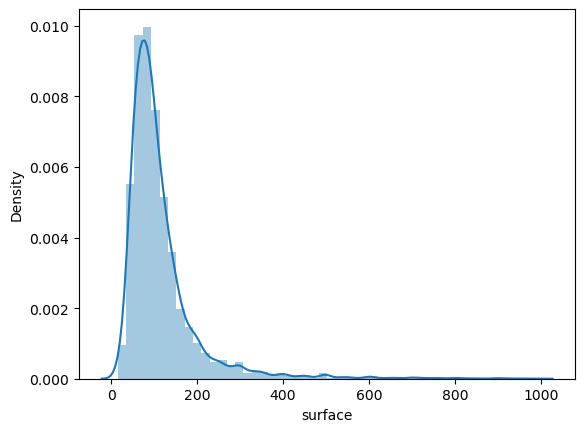

In [474]:
sns.distplot(df_test["surface"])

In [475]:
df_test["n_rooms"].describe()

count    19783.000000
mean         3.279789
std          1.329873
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          9.000000
Name: n_rooms, dtype: float64

<AxesSubplot:xlabel='n_rooms', ylabel='Density'>

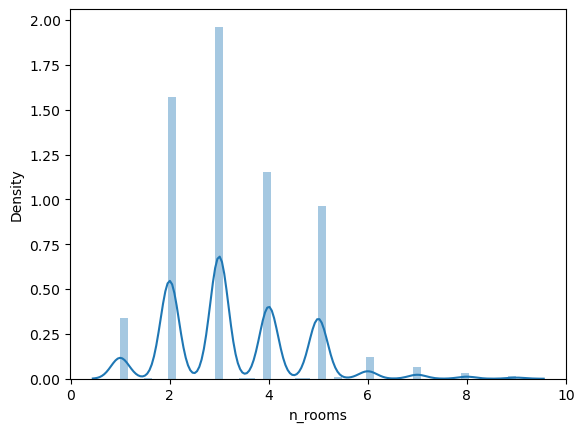

In [476]:
sns.distplot(df_test["n_rooms"])

Surface is approximately normal so we will impute the mean and for n_rooms we will go with the median.

In [477]:
# Surface 
from sklearn.impute import SimpleImputer
imputer_mean = SimpleImputer(strategy='mean')
imputer_mean.fit(df_test[["surface"]])
df_test["surface"] = imputer_mean.transform(df_test[["surface"]])

In [478]:
sum(df_test["surface"].isna())

0

In [479]:
imputer_median = SimpleImputer(strategy='median')
imputer_median.fit(df_test[["n_rooms"]])
df_test["n_rooms"] = imputer_median.transform(df_test[["n_rooms"]])

In [480]:
sum(df_test["n_rooms"].isna())

0

Finally we can fill the missing values in the bathroom column.

In [481]:
#X_scaled_pol.shape
#model_bathrooms.coef_

In [482]:
########
'''
# Select rows with missing values in n_bathrooms column
poly = PolynomialFeatures(degree=2)
scaler=StandardScaler()
scaler_=StandardScaler()
mask = df_test['n_bathrooms'].isna()
df_test_no_nan=df_test[~mask]
scaler_.fit(np.array(df_test_no_nan["n_bathrooms"])[:,np.newaxis])

X_scaled = scaler.fit_transform(df_test.loc[mask, ['surface', 'n_rooms']])
X_scaled_pol = poly.fit_transform(X_scaled)
predictions_scaled_log = model_bathrooms.predict(X_scaled_pol)
predictions_log = scaler_.inverse_transform(predictions_scaled_log[:, np.newaxis])

predictions=np.exp(predictions_log)
df_test.loc[mask, 'n_bathrooms'] = predictions

# Verify that the missing values have been filled in
print(df_test['n_bathrooms'].isna().sum())  # should output 0
'''

'\n# Select rows with missing values in n_bathrooms column\npoly = PolynomialFeatures(degree=2)\nscaler=StandardScaler()\nscaler_=StandardScaler()\nmask = df_test[\'n_bathrooms\'].isna()\ndf_test_no_nan=df_test[~mask]\nscaler_.fit(np.array(df_test_no_nan["n_bathrooms"])[:,np.newaxis])\n\nX_scaled = scaler.fit_transform(df_test.loc[mask, [\'surface\', \'n_rooms\']])\nX_scaled_pol = poly.fit_transform(X_scaled)\npredictions_scaled_log = model_bathrooms.predict(X_scaled_pol)\npredictions_log = scaler_.inverse_transform(predictions_scaled_log[:, np.newaxis])\n\npredictions=np.exp(predictions_log)\ndf_test.loc[mask, \'n_bathrooms\'] = predictions\n\n# Verify that the missing values have been filled in\nprint(df_test[\'n_bathrooms\'].isna().sum())  # should output 0\n'

In [483]:
# Select rows with missing values in n_bathrooms column

#poly = PolynomialFeatures(degree=2)

#scaler=StandardScaler()
#scaler_=StandardScaler()
mask = df_test['n_bathrooms'].isna()
#df_test_no_nan=df_test[~mask]
#scaler_.fit(np.array(df_test_no_nan["n_bathrooms"])[:,np.newaxis])

X_scaled = scaler1.transform(df_test.loc[mask, ['surface', 'n_rooms']])
#X_scaled_pol = poly.fit_transform(X_scaled)
predictions_scaled_log = model_bathrooms.predict(X_scaled) #(X_scaled_pol)
predictions_log = scaler3.inverse_transform(predictions_scaled_log[:, np.newaxis]) #scaler_.inverse_transform(predictions_scaled_log.reshape(-1, 1))
predictions=np.exp(predictions_log)
df_test.loc[mask, 'n_bathrooms'] = predictions

# Verify that the missing values have been filled in
print(df_test['n_bathrooms'].isna().sum())  # should output 0

0


In [484]:
'''
# Select rows with missing values in n_bathrooms column
poly = PolynomialFeatures(degree=2)
scaler=StandardScaler()
scaler_=StandardScaler()
mask = df_test['n_bathrooms'].isna()
df_test_no_nan=df_test[~mask]
scaler_.fit(np.array(df_test_no_nan["n_bathrooms"]).reshape(-1, 1))

scaler_.fit(df_test.loc[~mask, ['surface', 'n_rooms']])

X_scaled = scaler.fit_transform(df_test.loc[mask, ['surface', 'n_rooms']])
X_scaled_pol = poly.fit_transform(X_scaled)
predictions_scaled_log = model_bathrooms.predict(X_scaled_pol)
predictions_log = scaler_.inverse_transform(np.array(predictions_scaled_log))
predictions=np.exp(predictions_log)
df_test.loc[mask, 'n_bathrooms'] = predictions

# Verify that the missing values have been filled in
print(df_test['n_bathrooms'].isna().sum())  # should output 0
'''

'\n# Select rows with missing values in n_bathrooms column\npoly = PolynomialFeatures(degree=2)\nscaler=StandardScaler()\nscaler_=StandardScaler()\nmask = df_test[\'n_bathrooms\'].isna()\ndf_test_no_nan=df_test[~mask]\nscaler_.fit(np.array(df_test_no_nan["n_bathrooms"]).reshape(-1, 1))\n\nscaler_.fit(df_test.loc[~mask, [\'surface\', \'n_rooms\']])\n\nX_scaled = scaler.fit_transform(df_test.loc[mask, [\'surface\', \'n_rooms\']])\nX_scaled_pol = poly.fit_transform(X_scaled)\npredictions_scaled_log = model_bathrooms.predict(X_scaled_pol)\npredictions_log = scaler_.inverse_transform(np.array(predictions_scaled_log))\npredictions=np.exp(predictions_log)\ndf_test.loc[mask, \'n_bathrooms\'] = predictions\n\n# Verify that the missing values have been filled in\nprint(df_test[\'n_bathrooms\'].isna().sum())  # should output 0\n'

In [485]:
df_train.columns

Index(['id', 'price', 'balcony', 'conditions', 'construction_year', 'latitude',
       'longitude', 'floor', 'garden', 'n_bathrooms', 'elevator', 'n_rooms',
       'proximity_to_center', 'surface', 'price_log', 'city',
       'population_density', 'city_Milan', 'city_Rome', 'city_Venice',
       'city_nan', 'age'],
      dtype='object')

In [486]:
df_test.columns


Index(['id', 'balcony', 'conditions', 'construction_year', 'latitude',
       'longitude', 'floor', 'garden', 'n_bathrooms', 'elevator', 'n_rooms',
       'proximity_to_center', 'surface', 'city', 'population_density', 'age'],
      dtype='object')

Floor, age and construction year, elevator (no energy efficiency, total floors, expenses) - the same strategies as before

In [487]:
# Create an instance of SimpleImputer with median strategy
imputer = SimpleImputer(strategy='median')

# Select the columns to impute
cols_to_impute = ['floor']

# Fit the imputer on the selected columns
imputer.fit(df_test[cols_to_impute])

# Impute the missing values in the selected columns
df_test[cols_to_impute] = imputer.transform(df_test[cols_to_impute])

In [488]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(df_test[['construction_year']])
df_test["construction_year"]=imputer.transform(df_test[["construction_year"]])
df_test["age"] = df_test["age"].fillna(2023 - df_test[df_test["age"].isna()]["construction_year"])

In [489]:
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(df_test[['elevator']])
df_test["elevator"]=imputer.transform(df_test[["elevator"]])

Conditions and geographic data

We decided to drop them during training, here we will fill conditions with median (there are 4 discrete categories). Since geographic data are related and.

In [490]:
df_test["conditions"].describe()

count    19277.000000
mean         1.427919
std          0.904013
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          3.000000
Name: conditions, dtype: float64

In [491]:
df_test["conditions"].value_counts()

1.0    9264
2.0    4496
3.0    3090
0.0    2427
Name: conditions, dtype: int64

In [492]:
imputer = SimpleImputer(strategy='median')
imputer.fit(df_test[['conditions']])
df_test["conditions"]=imputer.transform(df_test[["conditions"]])

In [493]:
df_test["city"].value_counts()

Rome      10506
Milan      6122
Venice     3150
Name: city, dtype: int64

Test dataset contains again 3 cities: Rome, Milan, Venice, 3 discrete categories. Hence, we will choose the one with the highest probability, so we will use the mode strategy. It is not a perfect approach but considering that we are missing only 10 data points and that these variables are not crucial in predicting apartment prices, we will stick with it. Hence, we will predict Rome for 10 missing observations. So we can fill the missing values for population_density and city.

In [494]:
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(df_test[['city', 'population_density']])
df_test[["city", "population_density"]]=imputer.transform(df_test[["city", "population_density"]])

When it comes to proximity to the center as well as the longitude and latitude, we consider their distributions for Rome as this is the city which we assumed for the missing observations. We know that these 10 observations have these variables missing at the same time.

In [495]:
df_test[df_test["city"]=="Rome"]["proximity_to_center"].describe() 

count    10506.000000
mean         0.994332
std          0.029684
min          0.787488
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: proximity_to_center, dtype: float64

In [496]:
# we can see that mean is almost 1 and vast majority
# of observations is 1 (25% quantile and even lower quantiles), so we will just input 1 for the missing observations
# that would be both median or mode inputation strategy
df_test.loc[df_test["proximity_to_center"].isna(), "proximity_to_center"] = 1.000000

In [497]:
df_test[df_test["city"]=="Rome"]["latitude"].describe()

count    10506.000000
mean        41.880810
std          0.065120
min         41.708118
25%         41.850300
50%         41.889100
75%         41.922988
max         42.098397
Name: latitude, dtype: float64

In [498]:
df_test[df_test["city"]=="Rome"]["longitude"].describe()

count    10506.000000
mean        12.484662
std          0.090650
min         12.245334
25%         12.433807
50%         12.479829
75%         12.540200
max         12.787200
Name: longitude, dtype: float64

In [499]:
# For latitude and longitude, we take mean inputation stategy, but mean for ROME.
df_test.loc[df_test["latitude"].isna(), "latitude"] = 41.880810
df_test.loc[df_test["longitude"].isna(), "longitude"] = 12.484662


In [500]:
encoder = OneHotEncoder()
encoder.fit(df_test[['city']])
city_encoded = encoder.transform(df_test[['city']])
column_names = encoder.get_feature_names(['city'])
df_test = pd.concat([df_test, pd.DataFrame(city_encoded.toarray(), columns=column_names)], axis=1)

In [501]:
if df_test.isna().sum().sum() > 0:
    print("There are NaN values in the DataFrame")
else:
    print("There are no NaN values in the DataFrame")

There are no NaN values in the DataFrame


## Applying our models

In [502]:
def undo_transformations(predictions, scaler, log_transform=True):
    # Rescale predictions
    predictions_rescaled = scaler.inverse_transform(predictions)
    # Undo logarithmic transformation if it was applied
    if log_transform:
        predictions_rescaled = np.exp(predictions_rescaled)
    return predictions_rescaled

In [503]:
# Reusing scalers scaled on training data for this scaling

X=df_test[['balcony', 'conditions', 'floor', 'garden',
       'n_bathrooms', 'elevator', 'n_rooms',
       'proximity_to_center', 'surface', 'age', 'city_Milan', 'city_Rome', 'city_Venice']]
#X_scaled=scalerX.fit_transform(X)
X_scaled=scalerX.transform(X) # use previous scaler, transform without fitting

In [504]:
y_log_scaled=gb.predict(X_scaled) #best_svr.predict(X_scaled)
y_predictions=undo_transformations(y_log_scaled[:, np.newaxis], scalerY)

In [505]:
y_predictions=pd.DataFrame(y_predictions)

In [506]:
y_predictions.describe()

,0
count,1.978800e+04
mean,4.196984e+05
std,4.494318e+05
min,1.297439e+04
25%,1.996826e+05
50%,2.938274e+05
75%,4.746804e+05
max,1.485226e+07


In [507]:
df_train["price"].describe()

count    4.308600e+04
mean     4.551312e+05
std      7.037257e+05
min      1.540000e+02
25%      1.990000e+05
50%      3.090000e+05
75%      4.950000e+05
max      3.550000e+07
Name: price, dtype: float64

In [508]:
y_predictions

,0
0,205302.525578
1,239396.328424
2,640674.319564
3,164908.231616
4,249822.305730
...,...
19783,330244.778056
19784,286116.777357
19785,358902.109035
19786,151831.723080


In [509]:
ids=df_test["id"]
df = pd.DataFrame({'id': ids, 'price': y_predictions.iloc[:, 0]})

# Export the dataframe to a CSV file
df.to_csv('price_predictions_rf.csv', index=False)

In [510]:
### k_fold CV


# MAYBE YOU CAN DROP ALL OTHERS AND TRY WITHOUT IRRELEVANT COLUMNS?


rf_prices
best_svr
gb


GradientBoostingRegressor(max_depth=7, n_estimators=200, random_state=9)